In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
from nltk.tokenize import word_tokenize
#from nltk import SnowballStemmer
from nltk import PorterStemmer
import re



In [43]:
# #Tokenization
# Tokenization
# Lowercasing
# Removing Punctuation and Special Characters
# Removing Stop Words
# Stemming and Lemmatization

def ligustic_modulation(text):
    ps = PorterStemmer()
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    #removing the word less than 2
    text = re.sub(r'\b\w{1,2}\b', '', text)
    word_tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    #stemming
    text = [ps.stem(w) for w in word_tokens if not w in stop_words]
    text = ' '.join(text)
    return text
 




   id                           title  \
0   1                Red Alarm (1995)   
1   2     End of the Innocence (????)   
2   3  Tales from the Campfire (2017)   
3   4            "Mr. Dressup" (1967)   
4   5    Juchitán de las locas (2002)   

                                         description        genre  
0  At the beginning of the 21st Century, a World ...       action  
1  Eighteen year-old Alex, 13 year-old Maggie, an...        drama  
2  Four friends plan a camping trip at a small ca...       horror  
3  In this series, Ernie Coombes hosts this simpl...       family  
4  According to legend, God gave Vincente Ferrer,...  documentary  
   id                           title  \
0   1                Red Alarm (1995)   
1   2     End of the Innocence (????)   
2   3  Tales from the Campfire (2017)   
3   4            "Mr. Dressup" (1967)   
4   5    Juchitán de las locas (2002)   

                                         description        genre  
0  begin centuri world war rag

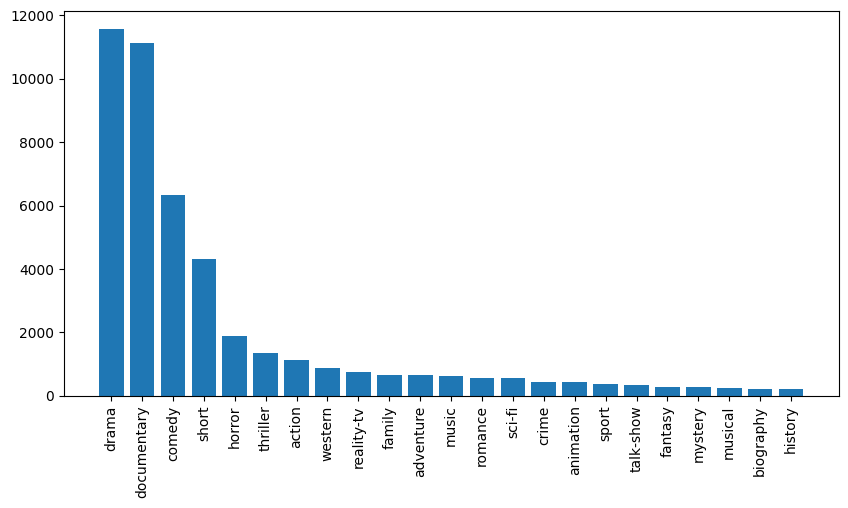

In [44]:
#id ::: title ::: description ::: genre
data = pd.read_csv('data/train.txt', sep=' ::: ', header=None, engine='python')
data.columns = ['id', 'title', 'description', 'genre']
print(data.head())
data['description'] = data['description'].apply(ligustic_modulation)
print(data.head()) 

data_test = pd.read_csv('data/test.txt', sep=' ::: ', header=None, engine='python')
data_test.columns = ['id', 'title', 'description', 'genre']
print(data_test.head())
data_test['description'] = data_test['description'].apply(ligustic_modulation)
print(data_test.head())
print(data_test['genre'].unique())

dict_genres = data['genre'].value_counts().to_dict()
print(dict_genres)

#visualize the data
plt.figure(figsize=(10, 5))
plt.bar(dict_genres.keys(), dict_genres.values())
plt.xticks(rotation=90)
plt.show()



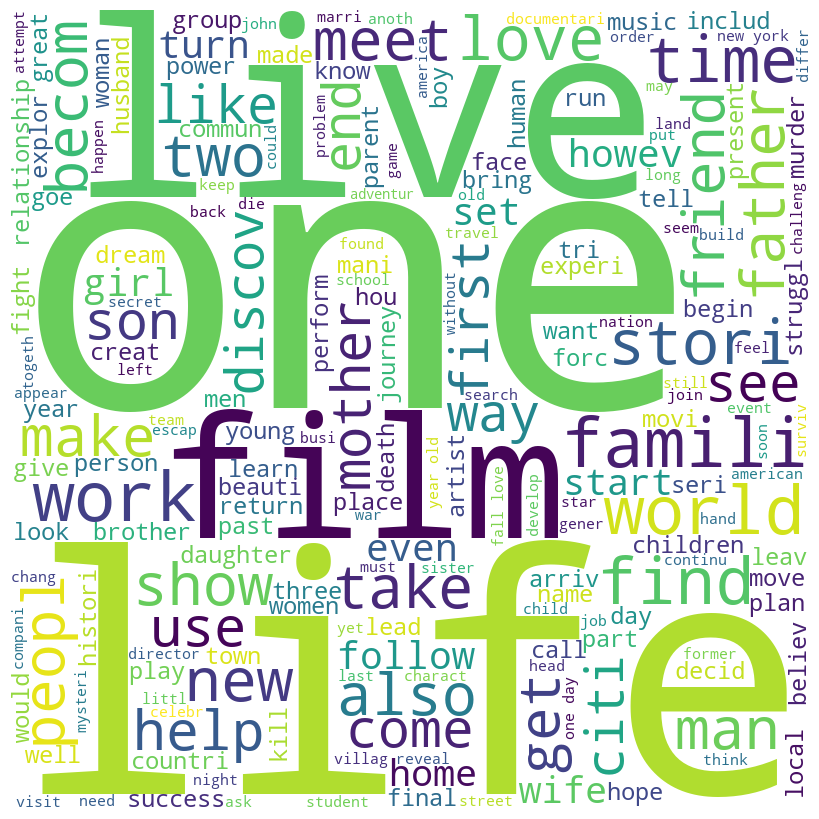

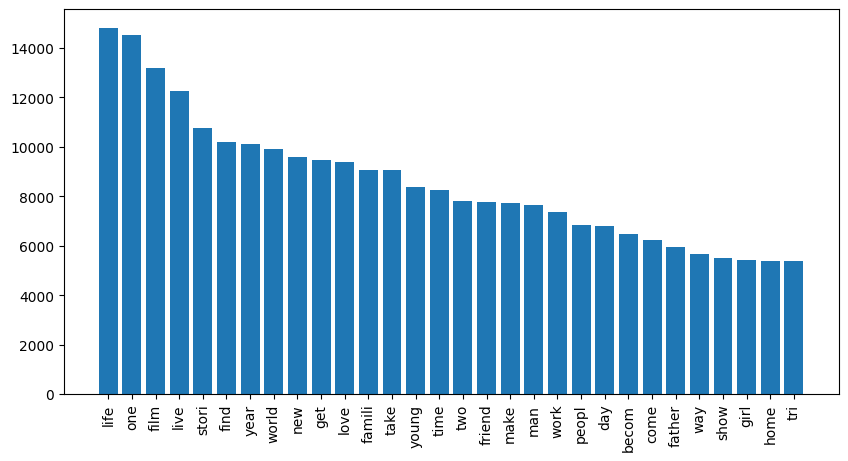

In [45]:
#visualize the word cloud
from wordcloud import WordCloud
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = set(stopwords.words('english')), 
                min_font_size = 10).generate(' '.join(data['description']))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

#visualize the frequency of the words
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X = cv.fit_transform(data['description'])
sum_words = X.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])
plt.figure(figsize=(10, 5))
plt.bar(frequency.iloc[:30]['word'], frequency.iloc[:30]['freq'])
plt.xticks(rotation=90)
plt.show()



In [46]:

import re
from collections import Counter
import numpy as np

def tokenize(text):
    tokens = re.findall(r'\b\w+\b', text)
    return tokens

def build_vocabulary(corpus, max_features=1000):
    word_counter = Counter()
    for text in corpus:
        tokens = tokenize(text)
        word_counter.update(tokens)
    
    most_common_words = word_counter.most_common(max_features)
    vocabulary = {word: i for i, (word, _) in enumerate(most_common_words)}
    return vocabulary

def text_to_bow(text, vocabulary):
    tokens = tokenize(text)
    bow_vector = np.zeros(len(vocabulary), dtype=int)
    
    for token in tokens:
        if token in vocabulary:
            index = vocabulary[token]
            bow_vector[index] += 1
    
    return bow_vector

def transform_corpus(corpus, vocabulary):
    return np.array([text_to_bow(text, vocabulary) for text in corpus])



In [47]:
import re
from collections import Counter
import numpy as np

def tokenize(text):
    tokens = re.findall(r'\b\w+\b', text.lower())
    return tokens

def build_vocabulary(corpus, max_features=1000):
    word_counter = Counter()
    for text in corpus:
        tokens = tokenize(text)
        word_counter.update(tokens)
    
    most_common_words = word_counter.most_common(max_features)
    vocabulary = {word: i for i, (word, _) in enumerate(most_common_words)}
    return vocabulary

def compute_tf(text, vocabulary):
    tokens = tokenize(text)
    tf_vector = np.zeros(len(vocabulary), dtype=float)
    token_count = Counter(tokens)
    
    for token, count in token_count.items():
        if token in vocabulary:
            index = vocabulary[token]
            tf_vector[index] = count / len(tokens)
    
    return tf_vector

def compute_idf(corpus, vocabulary):
    idf_vector = np.zeros(len(vocabulary), dtype=float)
    num_documents = len(corpus)
    for word in vocabulary:
        count = sum(1 for text in corpus if word in tokenize(text))
        if count > 0:
            idf_vector[vocabulary[word]] = np.log(num_documents / count)
    
    return idf_vector

def transform_corpus_tfidf(corpus, vocabulary, idf_vector):
    tfidf_matrix = []
    for text in corpus:
        tf_vector = compute_tf(text, vocabulary)
        tfidf_vector = tf_vector * idf_vector
        tfidf_matrix.append(tfidf_vector)
    return np.array(tfidf_matrix)

In [49]:
from collections import defaultdict
import numpy as np

def precision_recall_f1(y_true, y_pred):
    unique_labels = np.unique(y_true)
    precision = {}
    recall = {}
    f1_score = {}
    support = {}
    tp_sum = 0
    fp_sum = 0
    fn_sum = 0
    
    for label in unique_labels:
        tp = sum((y_pred == label) & (y_true == label))
        fp = sum((y_pred == label) & (y_true != label))
        fn = sum((y_pred != label) & (y_true == label))
        support[label] = sum(y_true == label)
        
        tp_sum += tp
        fp_sum += fp
        fn_sum += fn

        if tp + fp > 0:
            precision[label] = tp / (tp + fp)
        else:
            precision[label] = 0.0
        
        if tp + fn > 0:
            recall[label] = tp / (tp + fn)
        else:
            recall[label] = 0.0
        
        if precision[label] + recall[label] > 0:
            f1_score[label] = 2 * (precision[label] * recall[label]) / (precision[label] + recall[label])
        else:
            f1_score[label] = 0.0

    if tp_sum + fp_sum > 0:
        micro_precision = tp_sum / (tp_sum + fp_sum)
    else:
        micro_precision = 0.0
    if tp_sum + fn_sum > 0:
        micro_recall = tp_sum / (tp_sum + fn_sum)
    else:
        micro_recall = 0.0
    if micro_precision + micro_recall > 0:
        micro_f1_score = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall)
    else:
        micro_f1_score = 0.0
    return precision, recall, f1_score, support, micro_precision, micro_recall, micro_f1_score

def classification_report(y_true, y_pred):
    precision, recall, f1_score, support, micro_precision, micro_recall, micro_f1_score = precision_recall_f1(y_true, y_pred)
    unique_labels = np.unique(y_true)
    
    report = "              precision    recall  f1-score   support\n\n"
    for label in unique_labels:
        report += f"{label:>12}    {precision[label]:>9.2f}    {recall[label]:>6.2f}    {f1_score[label]:>8.2f}   {support[label]:>7}\n"
    
    # Calculate the overall accuracy
    accuracy = sum(y_true == y_pred) / len(y_true)
    
    macro_avg_precision = np.mean(list(precision.values()))
    macro_avg_recall = np.mean(list(recall.values()))
    macro_avg_f1_score = np.mean(list(f1_score.values()))
    
    weighted_avg_precision = np.average(list(precision.values()), weights=list(support.values()))
    weighted_avg_recall = np.average(list(recall.values()), weights=list(support.values()))
    weighted_avg_f1_score = np.average(list(f1_score.values()), weights=list(support.values()))

    report += "\n"
    report += f"    accuracy                         {accuracy:>6.2f}\n"
    report += "     macro avg    {0:>9.2f}    {1:>6.2f}    {2:>8.2f}  {3:>7}\n".format(
        macro_avg_precision, macro_avg_recall, macro_avg_f1_score, sum(support.values()))
    report += "    micro avg    {0:>9.2f}    {1:>6.2f}    {2:>8.2f}  {3:>7}\n".format(
        micro_precision, micro_recall, micro_f1_score, sum(support.values()))
    report += " weighted avg    {0:>9.2f}    {1:>6.2f}    {2:>8.2f}  {3:>7}\n".format(
        weighted_avg_precision, weighted_avg_recall, weighted_avg_f1_score, sum(support.values()))
    
    return report

# # Sample data
# y_test = np.array([0, 1, 2, 2, 2, 1, 0, 0, 1, 2])
# y_pred = np.array([0, 0, 2, 2, 1, 1, 0, 0, 1, 2])

# # Generate classification report
# print(classification_report(y_test, y_pred))


In [50]:
import numpy as np
from collections import Counter
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances

class KNN_Classifier:
    def __init__(self, n_neighbors=5, metric='cosine'):
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.fit_X = None
        self.fit_y = None
        #finding the id and its nearest neighbors
        self.nearest_id = {}
    
    def fit(self, X, y):
        self.fit_X = np.asarray(X)
        self.fit_y = np.asarray(y)
        return self
    def cosine_similarity(self, x1, x2):
        return np.dot(x1, x2) / (np.linalg.norm(x1) * np.linalg.norm(x2))
    def euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))
    def predict(self, X_test):
        X_test = np.asarray(X_test)
        distances = []
        if self.metric == 'cosine':
            distances = cosine_distances(X_test, self.fit_X)
            # for i in range(len(X_test)):
            #     for j in range(len(self.fit_X)):
            #         distances.append(self.cosine_similarity(X_test[i], self.fit_X[j]))
        elif self.metric == 'euclidean':
            distances = euclidean_distances(X_test, self.fit_X)
         
            # for i in range(len(X_test)):
            #     for j in range(len(self.fit_X)):
            #         distances.append(self.euclidean_distance(X_test[i], self.fit_X[j]))
        y_pred = []
        for dist in distances:
            nearest_indices = np.argsort(dist)[:self.n_neighbors]
            nearest_labels = self.fit_y[nearest_indices]
            self.nearest_id[nearest_indices[0]] = nearest_indices
            most_common_label = Counter(nearest_labels).most_common(1)[0][0]
            y_pred.append(most_common_label)
        
        return np.array(y_pred)



In [52]:
X_train = data['description']
X_test  = data_test['description']
y_train = data['genre']
y_test = data_test['genre']

# vocabulary = build_vocabulary(X_train, max_features=1000)

# idf_vector = compute_idf(X_train, vocabulary)
# X_train_tfidf = transform_corpus_tfidf(X_train, vocabulary, idf_vector)
# X_test_tfidf = transform_corpus_tfidf(X_test, vocabulary, idf_vector)
# bag_of_words = list(vocabulary.keys())


vocabulary = build_vocabulary(X_train, max_features=500)
X_train_bow = transform_corpus(X_train, vocabulary)
X_test_bow = transform_corpus(X_test, vocabulary)
bag_of_words = list(vocabulary.keys())
k = [1, 3, 5, 7, 9, 11, 13]
#return report, accuracy, macro_avg_precision, macro_avg_recall, macro_avg_f1_score, micro_precision, micro_recall, micro_f1_score, weighted_avg_precision, weighted_avg_recall, weighted_avg_f1_score
accuracy = {}
macro_avg_precision = {}
macro_avg_recall = {}
macro_avg_f1_score = {}
micro_precision = {}
micro_recall = {}
micro_f1_score = {}
weighted_avg_precision = {}
weighted_avg_recall = {}
weighted_avg_f1_score = {}


model = KNN_Classifier(n_neighbors=13, metric='cosine') # or metric='cosine' and the tf_idf formula 
model.fit(X_train_bow, y_train)
y_pred = model.predict(X_test_bow)
print("tf_idf results")
print(classification_report(y_test, y_pred))
print('------------------------------------------------------------\n')



# model = KNN_Classifier(n_neighbors=5, metric='cosine')
# model.fit(X_train_tfidf, y_train)
# y_pred = model.predict(X_test_tfidf)
# print(classification_report(y_test, y_pred))




tf_idf results
              precision    recall  f1-score   support

      action         0.28      0.08        0.12       197
   adventure         0.20      0.03        0.05       116
   animation         0.29      0.03        0.05        75
   biography         0.00      0.00        0.00        40
      comedy         0.35      0.31        0.33      1117
       crime         0.31      0.05        0.09        76
 documentary         0.51      0.76        0.61      1964
       drama         0.43      0.65        0.52      2042
      family         0.14      0.03        0.04       117
     fantasy         0.00      0.00        0.00        48
     history         0.00      0.00        0.00        36
      horror         0.36      0.15        0.21       331
       music         0.40      0.42        0.41       110
     musical         0.00      0.00        0.00        41
     mystery         0.00      0.00        0.00        48
  reality-tv         0.12      0.02        0.04       133
  

In [ ]:
#visualize the accuracies
plt.figure(figsize=(10, 5))
plt.bar(k, list(accuracy.values()))
#set plot to be 100 to 100 pixels
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter("{x:,.0f}"))
#give the title and the labels
plt.title('Accuracy')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.show()

#visualize the micro precision
plt.figure(figsize=(10, 5))
plt.bar(k, list(micro_precision.values()))
plt.xticks(rotation=90)
plt.title('Precision')
plt.xlabel('k')
plt.ylabel('Precision')

#visualize the micro recall
plt.figure(figsize=(10, 5))
plt.bar(k, list(micro_recall.values()))
plt.xticks(rotation=90)
plt.title('Recall')
plt.xlabel('k')
plt.ylabel('Recall')
plt.show()

#visualize the micro f1_score
plt.figure(figsize=(10, 5))
plt.bar(k, list(micro_f1_score.values()))
plt.xticks(rotation=90)
plt.title('F1_score')
plt.xlabel('k')
plt.ylabel('F1_score')
plt.show()


In [ ]:
correct = {}
#split the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data['description'], data['genre'], test_size=0.2, random_state=42)

vocabulary = build_vocabulary(X_train, max_features=1000)
X_train_bow = transform_corpus(X_train, vocabulary)
X_test_bow = transform_corpus(X_test, vocabulary)
bag_of_words = list(vocabulary.keys())

model = KNN_Classifier(n_neighbors=5, metric='cosine')
model.fit(X_train_bow, y_train)
for i in range(len(X_test)):
    X_test_test = np.array([X_test_bow[i]])
    genre, topAnwsers = model.predict(X_test_test)
    if y_test[i] == genre:
        if genre not in correct:
            correct[genre] = {}
        for j in topAnwsers:
            if data['genre'][j] == genre:
                correct[genre][j] = correct[genre].get(j, 0) + 1

print(correct)


In [53]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
correct = {'comedy': {34856: 1, 22646: 1, 34586: 2, 6038: 2, 21278: 1, 7731: 1, 23845: 1, 31908: 1, 9140: 1, 35192: 1, 8557: 1, 26084: 1, 25439: 1, 4354: 1, 7416: 1, 2088: 1, 31268: 1, 17928: 1, 40979: 2, 9890: 1, 4434: 1, 43996: 1, 21003: 3, 2449: 1, 29049: 1, 42933: 1, 6400: 2, 13198: 1, 21971: 1, 22133: 2, 30979: 1, 26378: 2, 43870: 4, 34230: 1, 41024: 1, 28817: 1, 11555: 1, 10594: 1, 16678: 1, 12143: 1, 10315: 1, 41986: 1, 38336: 1, 37017: 1, 40680: 2, 5366: 2, 38422: 1, 14759: 1, 27876: 1, 21649: 2, 23623: 2, 14057: 1, 11911: 1, 2161: 1, 33187: 1, 21999: 1, 5389: 3, 29268: 2, 22274: 1, 29351: 1, 24077: 1, 16084: 1, 36540: 1, 12369: 1, 19145: 1, 1119: 2, 40429: 1, 44383: 1, 39460: 1, 1171: 2, 3532: 2, 23036: 1, 929: 2, 41115: 1, 44981: 1, 33790: 1, 40246: 1, 19584: 1, 16352: 1, 28699: 1, 31569: 1, 8758: 1, 11885: 1, 28807: 1, 37043: 1, 40672: 1, 20083: 1, 43667: 1, 9942: 1, 16194: 1, 41757: 1, 7467: 2, 41234: 1, 42826: 1, 16643: 1, 27466: 2, 12771: 2, 13976: 1, 28775: 1, 28300: 1, 29189: 1, 31577: 1, 501: 1, 12994: 1, 19773: 1, 15611: 1, 17904: 2, 23447: 1, 38737: 1, 25398: 2, 6919: 3, 10458: 1, 8069: 1, 8851: 1, 7039: 1, 20697: 1, 36965: 1, 15552: 1, 3168: 1, 33466: 1, 17388: 1, 5126: 1, 5952: 2, 7967: 1, 1697: 1, 24206: 1, 21734: 1, 1894: 1, 28661: 1, 28363: 1, 2722: 1, 1377: 1, 20907: 1, 41114: 1, 941: 1, 19172: 1, 2606: 1, 13072: 1, 43835: 1, 9685: 1, 30901: 2, 23691: 2, 2859: 1, 38252: 1, 26981: 1, 28602: 1, 3004: 1, 44916: 1, 22093: 3, 40022: 1, 4123: 1, 2473: 1, 32630: 1, 13668: 1, 10884: 1, 29440: 1, 22513: 1, 26676: 1, 11276: 1, 36022: 1, 20817: 1, 25947: 1, 17225: 1, 6813: 1, 43299: 3, 9467: 1, 29132: 1, 5791: 1, 21375: 2, 44269: 1, 26359: 1, 14600: 1, 9849: 1, 29989: 1, 24949: 1, 41306: 1, 30185: 2, 18687: 1, 26098: 1, 17476: 2, 9359: 1, 28502: 1, 24498: 2, 11022: 1, 38560: 1, 14212: 1, 34145: 1, 29407: 1, 32897: 1, 31766: 1, 7715: 1, 44273: 1, 43242: 1, 2096: 1, 31116: 1, 14021: 1, 36202: 1, 35612: 1, 21087: 1, 32708: 1, 24297: 1, 12047: 1, 26984: 1, 41393: 1, 36915: 1, 36589: 1, 8894: 1, 44534: 1, 34321: 2, 36559: 2, 29307: 2, 30817: 1, 3097: 1, 9461: 1, 40634: 1, 26123: 1, 19827: 1, 37005: 1, 15347: 1, 38637: 1, 30199: 1, 5596: 1, 39559: 1, 23747: 1, 25466: 1, 38367: 1, 6855: 1, 16856: 1, 33526: 1, 30379: 1, 22623: 1, 7329: 1, 11510: 1, 23674: 1, 29901: 1, 36405: 1, 23836: 1, 41459: 1, 16610: 1, 26675: 1, 2277: 1, 4443: 1, 6773: 1, 14826: 2, 42340: 1, 36331: 1, 42014: 1, 18822: 1, 12308: 1, 1820: 1, 22024: 1, 2874: 2, 25429: 1, 26278: 1, 7577: 1, 1190: 2, 34674: 1, 10007: 1, 42175: 1, 35428: 1, 25986: 1, 7300: 1, 40487: 1, 15286: 1, 6820: 1, 4054: 1, 31697: 1, 9931: 1, 39783: 1, 37402: 1, 20999: 1, 32190: 1, 34229: 2, 33183: 1, 14166: 1, 44840: 1, 29699: 1, 29542: 1, 7588: 1, 38365: 1, 24977: 1, 39650: 1, 41506: 1, 20306: 1, 1296: 1, 3025: 1, 41902: 2, 33721: 1, 38351: 1, 3474: 1, 43348: 1, 16119: 1, 33533: 1, 15385: 1, 37775: 1, 14459: 1, 45079: 1, 5883: 1, 17436: 1, 42746: 1, 39853: 1, 29127: 1, 43147: 1, 26804: 1, 24182: 1, 5083: 1, 23908: 1, 25860: 1, 3976: 1, 40745: 1, 6260: 1, 15620: 1, 819: 1, 40254: 1, 39757: 1, 22940: 1, 28972: 2, 18262: 1, 20862: 1, 42818: 1, 17376: 1, 30259: 1, 25069: 1, 44867: 1, 34921: 1, 28486: 1, 26286: 1, 2393: 1, 9645: 1, 11301: 1, 36637: 1, 30622: 1, 42368: 1, 31815: 1, 43472: 1, 6499: 1, 40916: 1, 2936: 1, 31368: 1, 13783: 1, 37547: 1, 22738: 1, 22269: 1, 37546: 1, 37455: 1, 2200: 1, 42408: 1, 34109: 2, 25730: 1, 22757: 1, 14449: 1, 38057: 1, 18235: 1, 9334: 1, 2317: 1, 31741: 1, 34344: 1, 7456: 1, 36553: 1, 17637: 1, 43168: 1, 8101: 1, 32507: 1, 14104: 1, 6975: 1, 30045: 1, 15904: 1, 35567: 1, 22686: 1, 2116: 1, 4191: 1, 33751: 1, 36268: 1, 17280: 1, 40870: 1, 14422: 1, 25024: 1, 4244: 1, 34073: 1, 15375: 1, 24593: 1, 42326: 1, 25138: 1, 32587: 1, 15025: 1, 31297: 1, 40222: 2, 7914: 1, 10437: 1, 40298: 1, 4897: 1, 38257: 1, 5656: 1, 19382: 1, 34090: 1, 31964: 1, 19219: 1, 8505: 1, 25418: 1, 36525: 1, 43908: 1, 2750: 1, 3978: 1, 43765: 1, 18773: 1, 12547: 1, 4479: 1, 40100: 1, 34020: 1, 7870: 1, 43805: 1, 20395: 1, 24831: 1, 37794: 1, 18008: 1, 25264: 1, 29574: 1, 27313: 1, 39739: 1, 13856: 1, 18286: 1, 44002: 1, 40305: 1, 1618: 1, 6147: 1, 4227: 1, 32479: 2, 40148: 1, 13528: 1, 21100: 1, 27662: 1, 11999: 1, 16692: 1, 30263: 1, 4921: 1, 42494: 1, 9480: 1, 42558: 1, 42649: 1, 14198: 1, 31848: 1, 2291: 1, 511: 1, 37726: 1, 40817: 1, 38450: 1, 17892: 1, 19097: 1, 40730: 1, 41869: 1, 16922: 1, 41662: 1, 1634: 1, 8907: 1, 43217: 1, 33616: 1, 14835: 1, 24450: 1, 711: 1, 34427: 1, 13848: 1, 14605: 1, 35869: 1, 4584: 1, 19110: 1, 26241: 1, 7896: 1, 14040: 1, 41775: 1, 45133: 1, 37850: 1, 23859: 1, 11908: 1, 23414: 1, 6126: 1, 14899: 1, 42201: 1, 18778: 1, 18977: 1, 5907: 1, 12724: 1, 24968: 1}, 'crime': {19872: 1, 34144: 1, 28077: 1, 37533: 1, 15868: 1, 1318: 1, 24989: 1, 933: 1}, 'western': {37115: 2, 26700: 1, 4286: 3, 13732: 2, 28997: 3, 5917: 1, 34242: 7, 37631: 1, 35174: 1, 17900: 1, 22833: 2, 25648: 1, 37108: 3, 15425: 1, 20175: 2, 17374: 1, 41867: 1, 31322: 1, 4517: 1, 8663: 1, 37121: 2, 10475: 1, 26879: 1, 34611: 1, 38397: 3, 21757: 2, 15851: 1, 44615: 2, 12639: 1, 20628: 1, 22586: 2, 14176: 2, 14850: 1, 16163: 2, 40569: 3, 3471: 1, 616: 4, 6882: 1, 28501: 1, 21044: 3, 18702: 2, 28625: 1, 9154: 2, 11095: 1, 28106: 2, 22673: 4, 9706: 3, 6537: 1, 29161: 1, 45004: 3, 8169: 2, 36708: 2, 11283: 3, 41356: 1, 31191: 1, 258: 1, 1337: 2, 8064: 1, 17983: 2, 27162: 4, 10770: 1, 3574: 1, 27243: 3, 41514: 1, 14735: 1, 16375: 1, 28405: 2, 13235: 2, 20843: 4, 32504: 1, 22634: 1, 15692: 3, 3137: 1, 42729: 3, 42506: 1, 25701: 2, 34693: 1, 19400: 1, 18863: 1, 15877: 1, 31146: 1, 22724: 2, 2938: 1, 33730: 1, 37750: 1, 17945: 2, 4681: 1, 43903: 1, 20559: 1, 12248: 2, 19516: 1, 1204: 1, 41783: 1, 27116: 1, 35507: 1, 35530: 2, 31110: 1, 36760: 1, 7931: 1, 29193: 1, 30392: 1, 34424: 1, 38673: 1, 28995: 2, 6807: 2, 15363: 1, 32773: 1, 15808: 2, 26085: 1, 31060: 2, 20709: 1, 3074: 1, 27236: 1, 11891: 1, 31120: 1, 9588: 1, 21677: 1, 18804: 1, 6992: 2, 15207: 1, 10462: 1, 24606: 1, 13430: 1, 40371: 1, 39314: 1, 40765: 1, 15668: 1, 20124: 1, 1390: 1, 16878: 1, 19888: 1, 10122: 1, 24947: 1, 43936: 1, 316: 1, 21549: 1, 3950: 1, 4074: 1, 3090: 1, 22370: 1, 36834: 1, 25424: 1, 12329: 1, 19427: 2, 9789: 1, 16061: 1, 3199: 1, 35415: 1, 9213: 1, 7829: 1, 21841: 1, 39644: 1, 30763: 1, 32714: 1, 2563: 1, 38279: 1, 30364: 1, 43127: 1, 8636: 1}, 'drama': {33178: 1, 19199: 1, 4068: 1, 23452: 1, 38705: 1, 23855: 1, 34749: 1, 25473: 1, 29859: 1, 17680: 1, 2867: 1, 25228: 1, 26285: 2, 10265: 2, 27894: 1, 18458: 1, 44417: 1, 20668: 1, 39222: 1, 21481: 1, 24970: 1, 37809: 1, 40853: 2, 13830: 1, 475: 1, 14219: 1, 11408: 2, 9648: 2, 20978: 2, 6833: 1, 26050: 2, 14405: 3, 5854: 1, 35779: 1, 22323: 1, 43914: 1, 20896: 1, 3751: 1, 32849: 1, 35314: 1, 15371: 1, 18587: 1, 22838: 1, 3909: 1, 6305: 2, 1941: 1, 13495: 1, 27616: 1, 31992: 3, 6503: 2, 4408: 2, 12406: 1, 4832: 2, 14532: 1, 8364: 1, 36386: 1, 16957: 1, 44533: 2, 7008: 1, 32842: 2, 29723: 1, 6174: 1, 35108: 1, 13882: 2, 29301: 1, 17888: 1, 29048: 3, 18368: 1, 40442: 1, 15488: 1, 12152: 1, 2610: 1, 42358: 3, 28630: 1, 33846: 1, 39248: 1, 12387: 1, 44557: 1, 16307: 1, 31325: 1, 35078: 1, 30657: 1, 42659: 1, 22858: 1, 6853: 1, 2280: 1, 1375: 1, 29116: 1, 41340: 1, 17102: 2, 24132: 1, 15862: 1, 42894: 2, 13969: 3, 38128: 1, 40933: 2, 29894: 1, 18367: 2, 312: 2, 37718: 2, 44402: 1, 41678: 1, 14143: 2, 30519: 1, 1477: 1, 41487: 1, 38206: 1, 1162: 1, 1321: 1, 28005: 4, 19753: 1, 2774: 1, 2705: 1, 30691: 1, 16280: 1, 2382: 1, 14403: 1, 35969: 1, 39515: 1, 41500: 1, 33793: 1, 30303: 1, 29364: 1, 23803: 3, 31914: 1, 30508: 1, 23824: 1, 25299: 1, 4843: 1, 33960: 1, 33571: 3, 11759: 3, 4923: 3, 26942: 2, 6937: 1, 34970: 1, 5030: 1, 11963: 1, 38147: 1, 11607: 1, 37011: 1, 16436: 3, 16623: 1, 3267: 1, 28928: 1, 21321: 1, 42209: 1, 19985: 2, 15897: 1, 918: 1, 38838: 1, 29654: 1, 38706: 2, 41268: 1, 38955: 1, 14420: 2, 30494: 5, 1144: 5, 22682: 2, 8209: 1, 9788: 2, 14237: 1, 22510: 3, 2192: 1, 7762: 1, 14173: 2, 43201: 2, 19857: 2, 16891: 2, 24058: 1, 43899: 1, 41338: 4, 24442: 2, 18502: 1, 20122: 1, 13115: 1, 24942: 1, 40122: 3, 29687: 2, 25624: 1, 35919: 1, 31466: 2, 11594: 2, 37070: 1, 6777: 1, 17016: 2, 43593: 1, 13218: 1, 32806: 1, 9135: 1, 8163: 1, 709: 1, 29889: 1, 33237: 2, 14016: 1, 41855: 3, 20927: 1, 9420: 1, 22382: 1, 41746: 1, 22664: 1, 5895: 1, 12637: 1, 14381: 3, 22921: 3, 20001: 1, 13616: 1, 21341: 1, 33031: 1, 17755: 1, 25974: 3, 21657: 2, 5308: 1, 19392: 1, 19413: 1, 19971: 1, 14614: 1, 5477: 3, 39962: 2, 14873: 1, 12127: 1, 38576: 1, 4867: 1, 21280: 1, 35573: 1, 12245: 1, 23732: 3, 14314: 1, 665: 1, 18314: 1, 13930: 3, 34028: 1, 10660: 1, 31242: 2, 7969: 1, 26511: 1, 1341: 2, 10493: 1, 173: 1, 11063: 2, 3227: 2, 24542: 2, 38885: 1, 36100: 2, 23519: 3, 5742: 1, 19246: 1, 37355: 3, 20770: 2, 30833: 1, 29509: 2, 20882: 1, 43894: 1, 3192: 2, 18412: 1, 6057: 1, 27315: 1, 20383: 1, 38624: 1, 6459: 3, 39285: 3, 43482: 2, 8805: 1, 13079: 1, 10322: 1, 26433: 1, 21632: 1, 10674: 2, 31379: 2, 21095: 1, 23589: 1, 3772: 2, 20742: 1, 38864: 2, 902: 1, 14022: 1, 14907: 3, 5868: 2, 15738: 1, 10562: 1, 2886: 2, 4463: 1, 40003: 1, 30521: 1, 3296: 1, 19422: 2, 41497: 1, 7093: 1, 29548: 3, 36379: 1, 20166: 1, 45086: 1, 36747: 1, 38410: 2, 27926: 1, 28158: 1, 17011: 1, 24137: 2, 25839: 1, 30161: 1, 18535: 1, 34916: 1, 22147: 2, 33613: 1, 38581: 1, 13730: 1, 30678: 3, 36024: 2, 12903: 1, 31078: 2, 9018: 1, 7493: 1, 8262: 2, 31584: 2, 29234: 1, 1955: 1, 3189: 3, 26023: 1, 8559: 1, 19956: 1, 35810: 1, 31691: 1, 23417: 1, 17953: 1, 23309: 1, 39796: 1, 14012: 1, 27917: 2, 25712: 1, 6637: 1, 13589: 2, 15275: 1, 35888: 4, 36810: 1, 16681: 2, 11200: 1, 1826: 1, 35121: 1, 15837: 1, 13344: 1, 39393: 1, 10127: 1, 36198: 1, 17479: 2, 28278: 2, 5385: 1, 41616: 2, 20676: 2, 33248: 1, 18427: 1, 17314: 1, 8919: 1, 2604: 1, 27048: 1, 29591: 2, 40849: 2, 23819: 1, 105: 1, 9159: 1, 24912: 1, 30281: 3, 34003: 1, 13189: 1, 3012: 1, 3674: 2, 30283: 1, 23341: 1, 28447: 1, 5294: 2, 42990: 1, 2913: 1, 41982: 1, 35488: 1, 31653: 1, 26258: 1, 4766: 1, 36928: 1, 21855: 1, 11222: 1, 23303: 1, 21105: 2, 25844: 1, 39744: 1, 22877: 1, 22945: 1, 3424: 1, 24865: 1, 29997: 1, 23299: 2, 4180: 1, 24975: 1, 40156: 1, 26188: 1, 41609: 1, 42993: 1, 10982: 3, 32107: 1, 38166: 1, 38241: 1, 37630: 1, 16069: 1, 41424: 1, 27226: 1, 37029: 1, 34862: 1, 13911: 1, 852: 1, 19471: 1, 28914: 1, 36477: 1, 6279: 2, 17020: 2, 25517: 1, 35929: 2, 3197: 2, 9400: 1, 39664: 1, 7517: 1, 1002: 2, 13007: 2, 18273: 1, 11265: 1, 1365: 1, 42810: 1, 14696: 1, 910: 1, 12552: 2, 24090: 1, 32932: 1, 22418: 1, 43455: 2, 30125: 1, 31995: 2, 32094: 1, 26960: 1, 24298: 1, 37367: 1, 32823: 1, 29977: 1, 27742: 1, 42572: 1, 30173: 1, 23659: 1, 34497: 1, 23333: 2, 30934: 1, 16031: 1, 39032: 1, 9602: 1, 23343: 2, 19806: 1, 28346: 2, 63: 1, 27956: 2, 43492: 1, 42510: 1, 20621: 1, 1353: 1, 21404: 1, 7159: 1, 18615: 1, 10898: 1, 10824: 1, 19403: 1, 5639: 1, 40131: 1, 4786: 1, 37008: 1, 23969: 1, 30520: 3, 10346: 1, 32505: 1, 36661: 1, 9264: 1, 39823: 1, 30363: 1, 28145: 1, 29923: 1, 26970: 1, 19531: 1, 13022: 1, 15869: 2, 44487: 1, 239: 2, 20358: 1, 29369: 2, 7614: 2, 25977: 1, 8263: 1, 40070: 1, 29589: 1, 35160: 1, 6604: 2, 34908: 3, 1018: 2, 1757: 1, 21437: 1, 6288: 2, 32949: 1, 4295: 3, 13641: 1, 32158: 2, 28993: 1, 38735: 1, 21725: 1, 24817: 2, 25305: 2, 11958: 1, 11119: 1, 34110: 1, 18177: 1, 33396: 1, 17874: 1, 31889: 1, 9428: 1, 2656: 1, 6660: 1, 27280: 1, 14769: 1, 14207: 1, 11627: 1, 30196: 1, 9152: 1, 22504: 1, 35586: 2, 40517: 1, 44823: 2, 33047: 2, 44984: 1, 19146: 3, 40129: 1, 13615: 1, 41492: 1, 12585: 1, 21948: 1, 44117: 1, 5311: 1, 9660: 1, 30078: 1, 9205: 1, 26750: 2, 1594: 1, 40819: 1, 41108: 1, 28665: 1, 14142: 1, 9235: 1, 35774: 2, 32340: 1, 1403: 1, 12380: 1, 36725: 1, 37213: 1, 30118: 1, 37090: 1, 36499: 2, 29167: 1, 32586: 2, 37704: 1, 23857: 1, 14968: 1, 26025: 3, 40422: 1, 27474: 3, 5408: 1, 39930: 1, 22594: 1, 36850: 1, 34489: 1, 44265: 1, 16586: 2, 5815: 2, 2384: 2, 33017: 3, 9560: 1, 27664: 2, 34163: 1, 33062: 1, 7864: 1, 30808: 2, 23431: 1, 23216: 2, 28083: 1, 5864: 2, 26279: 2, 19831: 1, 39382: 1, 41476: 1, 43113: 1, 38989: 1, 3413: 1, 30088: 1, 27905: 2, 8331: 3, 19393: 1, 21135: 1, 4262: 1, 37263: 1, 26830: 1, 42126: 2, 38731: 1, 3896: 2, 39051: 1, 14038: 1, 3494: 1, 40139: 1, 35311: 1, 10627: 1, 1621: 2, 29722: 1, 39452: 1, 40786: 2, 11952: 2, 43890: 1, 22481: 1, 44144: 1, 21307: 1, 3416: 2, 808: 2, 41429: 1, 44097: 1, 6993: 1, 20339: 1, 28064: 1, 21622: 1, 26216: 1, 34961: 1, 30063: 1, 16817: 2, 31629: 1, 43119: 3, 28010: 2, 7693: 3, 38144: 1, 13647: 1, 30197: 1, 15112: 1, 25025: 2, 30715: 1, 14781: 1, 35483: 1, 12309: 1, 10925: 1, 35714: 1, 40614: 1, 39287: 1, 7098: 1, 23456: 1, 23861: 1, 17148: 1, 19891: 1, 22755: 1, 10860: 1, 527: 1, 2649: 2, 25291: 1, 1506: 1, 11173: 1, 40876: 1, 15860: 1, 3039: 2, 19798: 1, 32940: 3, 37865: 2, 23662: 1, 10570: 1, 18440: 1, 31729: 1, 29023: 1, 36335: 1, 2136: 1, 40332: 1, 11810: 2, 4807: 2, 33742: 1, 5376: 1, 44439: 1, 11565: 1, 14947: 1, 2580: 2, 29474: 2, 1238: 3, 42763: 1, 9524: 1, 42: 1, 9573: 1, 4481: 1, 35498: 1, 12019: 1, 31807: 1, 27733: 2, 11893: 1, 9758: 1, 34253: 1, 15320: 1, 29729: 1, 1626: 1, 33213: 1, 3502: 1, 35886: 2, 13129: 1, 28347: 1, 25846: 1, 14507: 1, 2435: 1, 26435: 1, 15092: 3, 3838: 1, 29429: 1, 37157: 2, 2553: 1, 15798: 1, 22466: 2, 4577: 1, 36040: 1, 16679: 2, 36388: 1, 9368: 1, 17925: 1, 1270: 1, 32585: 1, 22109: 1, 24835: 2, 21061: 1, 28802: 1, 12092: 1, 5447: 2, 10162: 2, 10491: 1, 34789: 1, 2820: 1, 16476: 1, 16533: 1, 8705: 1, 22410: 1, 35136: 1, 4371: 1, 6990: 1, 24621: 1, 34285: 1, 17973: 1, 36681: 1, 39654: 1, 29852: 1, 588: 1, 4188: 1, 5887: 1, 12189: 1, 60: 2, 44931: 2, 30371: 1, 7752: 1, 480: 1, 660: 2, 16105: 1, 28898: 1, 36913: 2, 8388: 1, 43450: 1, 36078: 1, 20070: 1, 10849: 1, 43030: 2, 19175: 1, 40585: 1, 35200: 1, 20486: 1, 16269: 1, 7546: 1, 41735: 1, 14491: 2, 22036: 1, 29994: 1, 41125: 1, 39971: 2, 42243: 2, 32176: 1, 40431: 1, 27311: 1, 9741: 1, 42813: 2, 42015: 1, 12641: 2, 11236: 1, 19699: 1, 34014: 1, 2875: 1, 32508: 3, 7380: 1, 15264: 1, 37823: 1, 479: 1, 12116: 1, 32879: 1, 28980: 1, 9998: 1, 8563: 1, 16879: 1, 2003: 1, 35265: 1, 15169: 1, 24124: 1, 44698: 1, 19662: 1, 6866: 2, 5704: 1, 4051: 1, 12344: 1, 20754: 1, 36091: 1, 2710: 1, 21506: 1, 28267: 1, 19536: 1, 35745: 1, 38095: 2, 22265: 2, 43647: 2, 41917: 1, 12186: 1, 2244: 1, 43579: 1, 19081: 1, 1577: 1, 11998: 1, 34122: 1, 9962: 1, 44435: 1, 4768: 1, 2958: 2, 36889: 1, 10838: 1, 42527: 1, 18673: 1, 3612: 1, 43954: 1, 3231: 1, 9233: 1, 40054: 1, 7071: 1, 15690: 3, 2436: 1, 9039: 1, 11486: 1, 8752: 1, 8484: 1, 16486: 1, 28012: 1, 33669: 1, 2379: 1, 31496: 1, 14537: 1, 38134: 1, 16372: 1, 5753: 1, 5021: 1, 25927: 2, 26659: 1, 22636: 1, 15486: 3, 6119: 2, 33175: 1, 27320: 1, 43787: 1, 36700: 1, 30603: 1, 44764: 1, 38818: 1, 40629: 1, 25078: 2, 36935: 1, 9925: 1, 20119: 1, 1068: 1, 29919: 2, 20525: 1, 25168: 1, 209: 1, 13239: 1, 21763: 2, 33989: 1, 39470: 1, 33103: 1, 33827: 1, 6388: 1, 13908: 1, 8657: 1, 21913: 1, 24981: 1, 33876: 1, 9799: 1, 9289: 1, 6890: 1, 8499: 1, 40620: 1, 41548: 1, 18942: 1, 42554: 2, 24625: 1, 37305: 2, 41395: 3, 7441: 1, 15637: 1, 14387: 1, 40693: 1, 40743: 1, 43518: 1, 26919: 1, 38162: 1, 34236: 1, 11204: 2, 36814: 1, 5658: 1, 41524: 1, 16774: 1, 9667: 1, 2207: 1, 1789: 1, 15162: 1, 32313: 1, 20544: 1, 3665: 1, 8236: 1, 44952: 1, 24771: 1, 45078: 1, 29988: 1, 5542: 1, 30277: 1, 29555: 1, 17897: 1, 16557: 1, 44431: 2, 13104: 2, 30170: 1, 26090: 1, 18841: 1, 27680: 1, 37790: 1, 23357: 1, 41647: 1, 34222: 1, 24931: 1, 34616: 1, 10250: 1, 37381: 1, 16387: 1, 29032: 2, 43577: 1, 26985: 1, 3830: 1, 40554: 1, 35860: 1, 12330: 1, 15345: 1, 14990: 1, 1801: 1, 10816: 1, 10930: 1, 42814: 1, 24876: 1, 23947: 1, 41062: 1, 16252: 2, 38683: 1, 19742: 1, 19266: 2, 40770: 1, 9489: 2, 34311: 1, 26679: 2, 41430: 1, 20264: 1, 16471: 1, 10168: 1, 25362: 1, 17368: 1, 25561: 1, 43909: 1, 33295: 1, 15638: 1, 41460: 1, 43799: 1, 26264: 1, 797: 2, 18581: 1, 44880: 1, 1079: 1, 42047: 1, 33348: 1, 42088: 2, 20818: 1, 43651: 2, 7054: 1, 34646: 1, 28976: 1, 2468: 1, 41284: 1, 36304: 1, 36071: 2, 20487: 1, 11986: 1, 20802: 1, 15164: 2, 36349: 1, 28919: 1, 29045: 1, 9067: 1, 19905: 1, 15015: 1, 39278: 1, 1979: 1, 34977: 1, 33612: 1, 26515: 1, 12672: 1, 23297: 1, 40465: 1, 1308: 1, 14536: 1, 38993: 1, 42424: 1, 24854: 1, 36996: 2, 38986: 1, 38829: 1, 36059: 1, 12289: 1, 12922: 1, 2619: 1, 26: 1, 40300: 1, 34933: 1, 9027: 1, 41385: 1, 249: 1, 43675: 1, 22902: 1, 23227: 1, 12756: 1, 13655: 1, 36259: 1, 25468: 1, 11793: 1, 6312: 1, 4301: 1, 41777: 1, 25495: 1, 32023: 1, 5466: 3, 21842: 1, 2410: 1, 28033: 1, 37758: 1, 32651: 1, 4672: 1, 29142: 1, 2570: 1, 40503: 2, 11729: 2, 18544: 1, 38292: 2, 19060: 1, 29081: 1, 38875: 1, 29053: 1, 5767: 1, 32470: 1, 10361: 1, 12830: 1, 39349: 1, 10385: 1, 9327: 1, 41140: 1, 33686: 1, 40903: 1, 23498: 2, 20417: 1, 11834: 1, 26218: 1, 11393: 1, 38547: 1, 464: 1, 14089: 1, 20868: 1, 33156: 1, 10864: 1, 15635: 2, 26082: 1, 2417: 1, 8601: 2, 1087: 2, 20463: 1, 9092: 1, 27281: 1, 4086: 1, 32420: 1, 38479: 1, 38486: 1, 792: 1, 21193: 1, 28812: 1, 23027: 1, 16951: 1, 7788: 2, 25368: 1, 1133: 1, 20941: 1, 43048: 2, 16725: 2, 37391: 2, 9728: 2, 9937: 1, 41649: 1, 21856: 1, 20708: 1, 13496: 1, 43618: 1, 44944: 1, 21782: 1, 12924: 1, 5898: 1, 6455: 1, 36714: 1, 9121: 1, 30792: 1, 33946: 1, 31916: 1, 38273: 1, 5236: 1, 15427: 1, 13427: 1, 20873: 1, 39001: 1, 9441: 1, 15792: 1, 31799: 1, 20592: 1, 5017: 1, 19691: 1, 44230: 1, 40938: 1, 13387: 1, 6159: 1, 12727: 1, 44769: 1, 24894: 2, 33322: 1, 10841: 1, 363: 1, 34531: 1, 44990: 1, 41992: 1, 31224: 1, 31640: 1, 35776: 1, 9004: 1, 19235: 1, 37905: 1, 43523: 1, 42250: 1, 34365: 1, 29389: 1, 45053: 1, 2766: 1, 27752: 1, 29713: 1, 22762: 1, 24329: 1, 7540: 1, 35855: 1, 25797: 1, 7865: 1, 21671: 1, 138: 1, 44186: 1, 12477: 1, 17592: 1, 44695: 2, 14954: 1, 25456: 1, 4912: 1, 12572: 1, 40358: 1, 9615: 1, 34923: 1, 8771: 1, 15309: 1, 15560: 1, 1208: 1, 6646: 1, 10956: 1, 24668: 1, 27070: 1, 30032: 1, 1100: 1, 22450: 1, 14986: 1, 42482: 1, 37957: 1, 6599: 1, 19153: 1, 1499: 1, 40028: 1, 7196: 1, 9720: 1, 21860: 1, 1112: 1, 3800: 1, 10790: 1, 17162: 1, 17071: 1, 21723: 1, 11862: 1, 35482: 1, 32519: 1, 21746: 1, 1137: 1, 4218: 1, 38012: 1, 19136: 1, 26120: 1, 4859: 1, 24598: 1, 28714: 1, 15614: 3, 39208: 1, 13379: 2, 39150: 1, 7326: 1, 10419: 1, 20365: 1, 31947: 1, 21595: 1, 19501: 1, 33445: 1, 20354: 1, 8488: 1, 33830: 1, 41431: 1, 37230: 1, 43225: 1, 38532: 1, 22005: 1, 37842: 1, 33726: 1, 40417: 1, 21013: 1, 19595: 2, 21554: 1, 16197: 1, 22477: 1, 29009: 1, 38157: 1, 20698: 1, 2450: 1, 16108: 1, 24630: 1, 37711: 1, 4773: 1, 20473: 1, 44139: 1, 18411: 1, 44217: 1, 44340: 1, 25480: 1, 33617: 1, 29315: 1, 15555: 1, 28575: 1, 487: 1, 3392: 1, 42667: 1, 35667: 1, 4177: 1, 21285: 1, 13098: 1, 18365: 1, 34871: 1, 2127: 1, 20233: 1, 1173: 1, 22756: 1, 31788: 1, 40695: 1, 22192: 1, 7852: 1, 14287: 1, 9526: 1, 25060: 2, 26495: 1, 44008: 1, 20054: 1, 145: 1, 16466: 1, 21230: 1, 33347: 1, 16782: 1, 7165: 1, 1702: 2, 11335: 1, 454: 1, 42664: 1, 6021: 1, 21308: 1, 35926: 1, 1708: 1, 41654: 1, 17505: 1, 23716: 1, 29824: 1, 33825: 1, 16842: 1, 12343: 1, 27129: 1, 17031: 1, 35257: 1, 33690: 1, 2876: 1, 2151: 1, 12071: 1, 37340: 1, 17158: 1, 41048: 1, 27937: 1, 44011: 1, 7315: 1, 19684: 1, 36643: 1, 9245: 1, 2490: 1, 20717: 1, 22991: 1, 1496: 1, 20729: 1, 24351: 1, 24589: 1, 13302: 1, 41812: 1, 42507: 1, 25614: 1, 4242: 1, 32634: 1, 35987: 1, 12334: 1, 320: 1, 36805: 1, 8506: 1, 44902: 1, 20011: 1, 21840: 1, 15267: 1, 34049: 1, 38233: 1, 7911: 1, 24448: 1, 32372: 1, 33915: 1, 41731: 1, 4530: 1, 21767: 1, 32867: 1, 13661: 1, 35637: 1, 23369: 1, 82: 1, 24478: 1, 10960: 1, 29433: 1, 20105: 1, 4954: 1, 17547: 1, 20155: 1, 4453: 1, 15680: 1, 32149: 1, 4905: 1, 30127: 1, 42615: 1, 4798: 1, 2921: 1, 41512: 1, 35278: 1, 15905: 1, 29252: 1, 32081: 1, 39167: 1, 21337: 1, 7482: 1, 26474: 1, 28298: 1, 17497: 1, 29099: 1, 10329: 1, 37245: 1, 2389: 1, 3217: 1, 35363: 1, 41720: 1, 44780: 1, 22750: 1, 29447: 1, 24091: 1, 8625: 1, 3667: 1, 27848: 1, 16281: 1, 30093: 1, 26453: 1, 21534: 1, 24320: 1, 33704: 1, 3344: 1, 1987: 1, 13949: 1, 26583: 1, 1628: 1, 6872: 1, 40761: 1, 44003: 1, 20844: 1, 33889: 1, 32959: 1, 375: 1, 15872: 1, 28104: 1, 5955: 1, 23544: 1, 15986: 1, 30260: 1, 10689: 1, 34544: 1, 13391: 1, 6707: 1, 11457: 1, 35561: 1, 15510: 1, 26471: 1, 21954: 1, 21328: 1, 24866: 1, 4833: 1, 5257: 1, 39506: 1, 5745: 1, 28420: 1, 24212: 1, 44643: 1, 23669: 1, 17111: 1, 7262: 1, 37231: 1, 119: 1, 19912: 1, 16205: 1, 11126: 1, 35446: 1, 3551: 1, 13474: 1, 4069: 1, 16843: 1, 9587: 1, 27850: 1, 37009: 1, 7903: 1, 14788: 1, 29911: 1, 2905: 1, 416: 1, 14426: 1, 7472: 1, 36211: 1, 25595: 1, 22121: 1, 11892: 1, 7163: 1, 6652: 1, 6676: 1, 28062: 1, 20665: 1, 20998: 1, 17977: 1, 37003: 1, 24966: 1, 23594: 1, 23765: 1, 29624: 1, 7348: 1}, 'documentary': {32720: 1, 31399: 2, 17557: 1, 21172: 1, 23288: 1, 28984: 1, 565: 3, 31395: 1, 16353: 4, 11066: 1, 40253: 1, 43347: 1, 6447: 2, 8853: 1, 17801: 2, 20089: 1, 38913: 1, 20312: 1, 433: 1, 17509: 1, 12812: 1, 21588: 1, 1115: 2, 7820: 4, 1064: 1, 10037: 1, 28797: 1, 13752: 1, 17864: 2, 44108: 1, 14502: 1, 35523: 1, 32231: 4, 36113: 1, 31298: 1, 16714: 4, 16376: 1, 43795: 4, 43306: 1, 28013: 1, 38030: 1, 25444: 1, 1824: 1, 13863: 4, 16056: 1, 30304: 2, 23542: 1, 12119: 3, 29209: 1, 19277: 1, 23931: 1, 22411: 2, 32998: 2, 28172: 1, 18666: 1, 36241: 2, 21346: 4, 37093: 1, 27108: 1, 31102: 1, 41796: 1, 26941: 1, 7122: 1, 4118: 1, 43131: 1, 41414: 1, 21399: 2, 35156: 1, 11228: 1, 40239: 1, 29947: 1, 39442: 1, 2338: 2, 16712: 3, 37802: 1, 1818: 1, 7356: 1, 37160: 1, 24944: 1, 41147: 1, 40057: 2, 44170: 2, 33912: 1, 44437: 1, 2071: 1, 35826: 2, 8607: 1, 22114: 2, 39118: 1, 16556: 1, 14471: 2, 29673: 3, 42585: 3, 12335: 1, 28437: 2, 40832: 2, 35251: 1, 12478: 2, 35144: 2, 9984: 1, 29949: 3, 39897: 3, 10338: 3, 45093: 2, 4198: 1, 27285: 1, 12115: 2, 29239: 1, 40771: 1, 29604: 1, 5828: 1, 5065: 1, 23474: 1, 5859: 2, 43582: 1, 17845: 1, 19547: 2, 29165: 1, 19674: 2, 27191: 1, 2962: 3, 40432: 3, 30968: 1, 26586: 1, 27517: 1, 42822: 2, 20605: 2, 9651: 1, 18837: 1, 746: 1, 22311: 1, 7505: 1, 21251: 1, 8536: 2, 43344: 1, 1643: 1, 29735: 1, 17472: 2, 36757: 1, 16461: 2, 27998: 3, 42938: 1, 26267: 1, 25999: 6, 35399: 1, 38341: 1, 27846: 2, 35527: 1, 34066: 1, 32264: 1, 8542: 1, 40074: 1, 29575: 2, 32465: 1, 32054: 1, 19750: 1, 14492: 2, 30041: 3, 10602: 2, 21631: 1, 15898: 1, 15311: 2, 11312: 1, 26498: 2, 22321: 2, 40314: 1, 27564: 2, 296: 1, 44495: 1, 41068: 1, 38201: 4, 1854: 2, 43733: 1, 12791: 1, 247: 1, 9125: 1, 25856: 3, 4674: 2, 35754: 2, 23580: 2, 26401: 2, 29333: 1, 36619: 1, 9161: 1, 11731: 3, 35470: 3, 37963: 2, 7948: 2, 36316: 1, 561: 1, 35254: 2, 24665: 1, 39398: 1, 23314: 2, 4107: 2, 15431: 2, 30919: 1, 18441: 1, 10190: 5, 11944: 2, 35809: 1, 42782: 3, 30734: 1, 16710: 3, 40827: 1, 42083: 1, 25892: 1, 16573: 1, 41297: 1, 22255: 1, 10304: 2, 7700: 1, 40244: 1, 25873: 1, 18004: 1, 4650: 2, 43738: 1, 20532: 2, 24076: 1, 32856: 1, 7213: 2, 18056: 1, 31938: 1, 37757: 4, 30139: 3, 11097: 2, 10958: 2, 29718: 1, 24228: 2, 38272: 1, 32139: 1, 34864: 2, 825: 1, 7770: 1, 12949: 1, 936: 4, 40067: 4, 9094: 1, 44305: 1, 4166: 3, 33256: 1, 9657: 1, 12697: 1, 8228: 2, 27249: 2, 39485: 2, 44560: 1, 6829: 3, 15504: 2, 37852: 2, 34307: 1, 27755: 1, 44801: 1, 34920: 1, 28163: 1, 11257: 4, 11780: 2, 8891: 1, 7373: 1, 32210: 1, 23959: 1, 26561: 3, 43238: 4, 9405: 2, 7130: 1, 1508: 1, 18270: 1, 36968: 2, 35468: 1, 10188: 1, 4940: 1, 25404: 2, 41690: 2, 12718: 2, 12371: 1, 3975: 1, 24447: 1, 19939: 1, 14361: 2, 28207: 1, 11371: 3, 5351: 1, 24168: 1, 27740: 2, 40069: 1, 19065: 1, 36524: 1, 18528: 1, 3018: 1, 20674: 1, 18265: 1, 24540: 1, 39522: 1, 36154: 1, 39708: 1, 2129: 4, 3763: 2, 43412: 1, 44799: 2, 27282: 1, 34741: 6, 20572: 1, 21233: 1, 1783: 2, 10086: 2, 24392: 2, 21448: 2, 1098: 2, 32815: 1, 17675: 1, 17391: 2, 12596: 3, 36920: 2, 43463: 2, 29130: 2, 16127: 3, 11231: 1, 41175: 1, 39653: 1, 29305: 1, 2884: 2, 4813: 2, 32878: 1, 3252: 1, 34511: 1, 22823: 2, 8131: 1, 12264: 1, 7132: 1, 21075: 2, 27842: 1, 39289: 1, 5415: 1, 31152: 1, 26298: 1, 232: 2, 3859: 1, 9820: 3, 10832: 1, 18612: 1, 35538: 2, 31394: 2, 9829: 1, 19104: 1, 10267: 1, 15574: 1, 28313: 1, 30948: 1, 33560: 2, 1682: 1, 22262: 1, 9210: 1, 9611: 1, 22521: 1, 5682: 1, 34744: 2, 35270: 1, 11901: 1, 4024: 3, 39024: 1, 38297: 1, 9807: 3, 25688: 1, 10309: 1, 24765: 1, 3287: 2, 12246: 2, 37163: 1, 34215: 1, 10678: 1, 30472: 1, 16049: 2, 31043: 1, 7428: 1, 492: 1, 21245: 2, 17588: 1, 18173: 1, 21381: 1, 3079: 2, 9051: 1, 6794: 3, 26382: 1, 12271: 1, 9576: 1, 15807: 1, 5874: 1, 20218: 2, 5446: 1, 36994: 1, 29774: 1, 21063: 2, 21031: 2, 26668: 2, 23936: 1, 43340: 1, 4667: 1, 44394: 1, 11626: 2, 7544: 1, 26998: 1, 13425: 2, 37138: 1, 14535: 2, 28541: 2, 943: 1, 5486: 1, 35925: 1, 2819: 1, 9339: 1, 33177: 1, 34872: 1, 21317: 1, 40495: 1, 8288: 1, 11778: 1, 13694: 1, 34113: 1, 7176: 2, 27205: 1, 20163: 1, 20752: 1, 1347: 1, 18492: 2, 2286: 1, 7432: 3, 43925: 1, 42762: 1, 45100: 2, 24235: 1, 4987: 1, 13048: 2, 3442: 1, 30171: 1, 22065: 2, 13687: 1, 4780: 2, 44738: 1, 29029: 1, 42878: 1, 40783: 2, 40202: 1, 18014: 1, 14521: 1, 26903: 3, 38482: 2, 21584: 2, 32909: 1, 29695: 2, 33124: 2, 6509: 1, 14639: 1, 27587: 1, 29903: 2, 23128: 3, 26190: 1, 20555: 1, 18383: 1, 7710: 1, 39353: 1, 23465: 1, 4799: 1, 5954: 2, 5754: 2, 684: 2, 38711: 1, 17175: 1, 37198: 1, 3125: 1, 39636: 1, 10057: 1, 15121: 1, 3448: 2, 26971: 1, 7776: 1, 27802: 2, 41792: 4, 8829: 1, 4812: 2, 35756: 1, 3771: 1, 10275: 1, 5394: 1, 14046: 2, 29432: 1, 10579: 1, 8706: 1, 36272: 1, 32222: 1, 27666: 1, 19961: 1, 40583: 1, 11974: 2, 3898: 1, 33111: 1, 37344: 1, 14289: 2, 12616: 1, 42229: 2, 21137: 1, 31703: 1, 18252: 1, 15841: 1, 27822: 2, 37903: 3, 29912: 3, 29980: 1, 27481: 1, 10794: 4, 30694: 2, 35599: 2, 15321: 1, 44521: 1, 15605: 1, 43755: 2, 13012: 2, 35766: 3, 23710: 1, 44467: 2, 32913: 1, 28903: 1, 11388: 2, 21037: 1, 15031: 2, 33811: 1, 31125: 2, 41663: 2, 24108: 2, 15043: 1, 12427: 1, 13825: 1, 9328: 3, 39771: 1, 16331: 1, 23039: 1, 15049: 1, 19444: 1, 36009: 2, 18694: 1, 4035: 1, 16988: 1, 40440: 1, 1303: 1, 8458: 1, 7718: 1, 10193: 1, 7116: 1, 30802: 1, 9209: 1, 33058: 1, 44134: 2, 31011: 2, 24663: 1, 13947: 1, 22138: 1, 28611: 1, 5290: 1, 10752: 2, 31923: 2, 10198: 1, 41543: 2, 24365: 1, 11357: 1, 1179: 1, 1722: 1, 24001: 1, 32910: 1, 24785: 2, 19754: 1, 3240: 1, 23797: 1, 22916: 2, 15016: 1, 6545: 1, 44031: 1, 31785: 1, 40035: 2, 32387: 1, 23810: 1, 9550: 1, 17506: 1, 25109: 1, 32323: 2, 8002: 1, 36617: 1, 41020: 1, 32084: 1, 42039: 1, 8257: 1, 14280: 1, 6200: 1, 41274: 1, 8586: 1, 8502: 3, 24791: 1, 13018: 1, 43560: 1, 36178: 2, 38696: 3, 28041: 1, 14884: 2, 24600: 1, 19165: 1, 35036: 1, 21555: 2, 22101: 2, 26309: 4, 25725: 3, 15477: 1, 31633: 1, 19271: 1, 37180: 1, 42968: 1, 21235: 4, 14442: 1, 1320: 1, 20784: 1, 23448: 2, 22754: 2, 19274: 1, 13802: 1, 30335: 1, 27339: 2, 42741: 1, 27258: 1, 31871: 2, 11537: 1, 4231: 2, 35519: 1, 30775: 1, 14738: 1, 41578: 1, 19564: 1, 27958: 1, 15235: 1, 37174: 2, 29510: 1, 38559: 1, 4520: 2, 6837: 2, 35870: 1, 20694: 1, 9050: 1, 14322: 1, 15706: 1, 42095: 1, 5393: 1, 8714: 1, 43956: 1, 21640: 1, 2091: 2, 23421: 1, 8814: 1, 8835: 2, 10408: 2, 7450: 1, 11316: 1, 4751: 1, 34423: 1, 33087: 1, 22515: 1, 20627: 1, 8757: 1, 42304: 1, 13225: 1, 1300: 1, 36448: 2, 34038: 1, 42384: 1, 17272: 1, 37690: 2, 11552: 1, 37584: 1, 41880: 1, 1123: 1, 36370: 1, 24992: 1, 23266: 1, 44721: 1, 18356: 1, 7867: 1, 36033: 1, 29203: 1, 26041: 2, 13112: 1, 35952: 3, 345: 2, 13245: 1, 35663: 1, 8623: 1, 3806: 1, 15938: 1, 42872: 1, 42794: 4, 2928: 2, 8923: 1, 14256: 2, 39262: 2, 32925: 2, 801: 1, 43232: 1, 9898: 2, 35388: 2, 14607: 2, 43694: 1, 12779: 1, 29361: 1, 41564: 2, 42098: 1, 42833: 1, 29969: 1, 10383: 2, 44407: 2, 39217: 2, 34454: 2, 4465: 1, 6648: 1, 4858: 1, 19743: 1, 28711: 1, 22006: 1, 4120: 1, 1026: 1, 1969: 1, 17098: 2, 43125: 1, 32020: 1, 34320: 1, 17821: 1, 5703: 1, 32109: 2, 15135: 1, 10643: 1, 15647: 1, 26205: 2, 11761: 2, 36105: 1, 41265: 1, 10672: 1, 21451: 1, 21053: 1, 42007: 1, 31709: 1, 12345: 1, 6947: 2, 5079: 1, 38270: 1, 22512: 1, 41860: 3, 31316: 1, 30294: 1, 38573: 2, 44095: 1, 10801: 1, 23956: 1, 43508: 2, 11701: 1, 23721: 1, 24126: 1, 33574: 6, 33167: 2, 355: 1, 7660: 2, 22219: 1, 44781: 1, 10412: 2, 35921: 2, 4205: 1, 40768: 1, 44787: 2, 35191: 1, 43782: 1, 897: 1, 32169: 1, 12632: 1, 38666: 1, 1993: 1, 13997: 1, 16629: 2, 32209: 1, 26337: 1, 37915: 1, 44482: 2, 4613: 2, 43491: 2, 39265: 1, 28946: 1, 1664: 1, 43114: 1, 18207: 1, 7475: 1, 17370: 1, 30569: 1, 25410: 1, 39207: 1, 20137: 1, 12112: 1, 30613: 1, 21836: 1, 31573: 1, 1696: 1, 25778: 2, 21026: 3, 35671: 1, 17294: 1, 22650: 1, 35750: 1, 36187: 1, 4213: 1, 11141: 1, 44192: 3, 29195: 1, 24473: 1, 6229: 1, 4515: 1, 13789: 1, 21548: 1, 38466: 1, 39626: 1, 22237: 1, 8574: 1, 30540: 1, 27945: 1, 41715: 1, 31351: 2, 8910: 2, 30990: 2, 27614: 1, 10466: 2, 12101: 1, 37933: 1, 27650: 1, 4001: 1, 42996: 1, 19381: 1, 21182: 1, 15781: 1, 24466: 1, 41246: 1, 286: 1, 4881: 1, 21325: 1, 19341: 1, 11762: 1, 9175: 1, 41029: 2, 37601: 1, 43821: 1, 31478: 1, 24140: 4, 28672: 2, 16005: 4, 6032: 1, 12466: 1, 2806: 1, 19502: 1, 5605: 1, 34217: 2, 34891: 1, 29175: 1, 23515: 2, 11773: 1, 24266: 1, 38073: 1, 5346: 1, 22209: 1, 617: 1, 40331: 1, 42542: 1, 40791: 1, 21792: 1, 23472: 1, 11950: 2, 41789: 2, 31599: 1, 43320: 1, 6824: 1, 35199: 2, 30816: 1, 30585: 1, 15511: 1, 43076: 1, 39903: 1, 31974: 1, 12689: 1, 19238: 2, 25355: 1, 23990: 2, 30095: 1, 11355: 1, 36385: 2, 6847: 2, 15294: 3, 1141: 1, 8497: 1, 27568: 1, 40902: 1, 20644: 1, 20413: 1, 38931: 1, 42786: 1, 23298: 1, 241: 1, 24068: 1, 42035: 1, 38868: 1, 25063: 1, 15291: 2, 33357: 1, 20075: 1, 18350: 1, 39989: 1, 43480: 2, 486: 1, 41588: 1, 39548: 2, 9968: 1, 39069: 2, 36766: 2, 44286: 1, 9023: 3, 12663: 1, 9812: 1, 34340: 4, 16101: 1, 36153: 2, 16809: 1, 23454: 1, 39753: 1, 20542: 1, 18253: 1, 25057: 1, 45010: 1, 37287: 1, 25680: 5, 37562: 1, 5716: 2, 41416: 1, 33964: 1, 15000: 1, 23180: 2, 27471: 2, 17176: 1, 10482: 2, 21043: 2, 12669: 1, 4106: 2, 4460: 1, 27612: 1, 24252: 1, 37478: 1, 543: 1, 22974: 2, 12523: 5, 15889: 2, 432: 2, 5622: 1, 24044: 1, 37924: 1, 39669: 1, 16210: 1, 41167: 1, 11989: 1, 40990: 1, 25811: 1, 19948: 1, 4474: 2, 13878: 1, 1354: 1, 10191: 1, 184: 1, 44765: 2, 39026: 1, 38136: 1, 19731: 1, 32469: 1, 20757: 2, 20385: 2, 1898: 2, 38274: 1, 12823: 1, 10453: 2, 32301: 2, 40141: 1, 31863: 1, 42402: 1, 9943: 1, 25996: 1, 29084: 1, 39253: 1, 44983: 1, 10026: 3, 5038: 1, 27384: 1, 17794: 1, 13374: 1, 44130: 2, 18420: 1, 26487: 1, 33096: 1, 19098: 1, 7397: 1, 26763: 1, 7343: 1, 32963: 1, 6606: 1, 1292: 1, 7502: 1, 18562: 1, 37867: 1, 31560: 1, 17468: 1, 8183: 3, 12740: 1, 28000: 1, 29584: 1, 11172: 1, 37072: 1, 37146: 1, 35340: 1, 18595: 1, 6232: 1, 4314: 2, 31775: 1, 31208: 1, 15733: 1, 8725: 1, 5573: 1, 8171: 1, 16743: 1, 25115: 1, 39197: 1, 33758: 1, 44914: 1, 40004: 1, 10844: 1, 40209: 2, 23964: 1, 1985: 1, 1149: 1, 18656: 1, 18011: 1, 37223: 1, 36256: 2, 20852: 1, 28846: 1, 21761: 1, 1864: 1, 42750: 1, 21264: 1, 8316: 1, 28460: 1, 45051: 1, 25: 2, 977: 1, 18452: 1, 7927: 1, 14808: 1, 8693: 1, 30104: 2, 23222: 1, 28745: 1, 1333: 1, 42922: 2, 18985: 1, 42278: 1, 16487: 1, 19249: 1, 3527: 1, 17670: 1, 21416: 1, 34776: 1, 13981: 1, 21192: 1, 24585: 1, 12384: 1, 3042: 1, 23211: 1, 4043: 2, 39375: 1, 23396: 1, 41464: 1, 27627: 2, 18961: 1, 43816: 1, 41883: 1, 33662: 1, 34266: 1, 31226: 2, 1680: 1, 21919: 1, 18373: 1, 25241: 2, 3253: 3, 12066: 1, 16866: 1, 7650: 2, 3831: 1, 31284: 1, 42060: 1, 9954: 1, 12810: 1, 21803: 2, 5911: 1, 26787: 1, 10592: 1, 19000: 1, 41296: 3, 10551: 1, 5578: 2, 2375: 1, 5110: 2, 8401: 2, 35513: 1, 35175: 1, 30554: 1, 33160: 2, 18913: 1, 18063: 1, 18984: 1, 35426: 1, 14618: 1, 21752: 1, 14464: 1, 22995: 1, 39185: 1, 20033: 2, 40966: 1, 2170: 1, 16367: 1, 23418: 1, 35455: 1, 9939: 1, 10000: 1, 8532: 1, 10735: 1, 37015: 1, 12171: 1, 11337: 1, 44024: 1, 36141: 1, 21883: 1, 285: 1, 12854: 1, 5199: 1, 33332: 2, 33249: 1, 24391: 1, 36262: 1, 10480: 2, 13122: 2, 39408: 1, 8475: 1, 38027: 1, 36706: 1, 22141: 2, 19757: 1, 31546: 1, 19251: 1, 10030: 1, 10927: 1, 30073: 1, 20356: 1, 5066: 1, 28291: 1, 27544: 1, 23171: 1, 37271: 1, 40910: 1, 6269: 1, 41400: 1, 4727: 1, 31409: 1, 799: 1, 23160: 1, 8419: 1, 2993: 1, 43182: 1, 42720: 1, 30325: 1, 44526: 1, 4679: 1, 33778: 1, 18601: 2, 25111: 1, 38384: 1, 40117: 1, 27976: 1, 32014: 1, 28456: 2, 11628: 1, 17322: 1, 7124: 1, 28971: 2, 149: 1, 19285: 1, 30589: 1, 35939: 2, 16824: 1, 23347: 1, 9486: 1, 24796: 1, 5598: 1, 30748: 1, 20789: 1, 10873: 1, 24941: 1, 10976: 1, 36440: 1, 13933: 1, 37103: 1, 39624: 1, 20684: 1, 23762: 2, 38121: 1, 13657: 1, 38317: 1, 21642: 1, 20069: 1, 29953: 1, 34143: 1, 37131: 1, 35811: 1, 8174: 1, 24635: 1, 5599: 2, 12857: 2, 24274: 1, 37224: 1, 33097: 1, 26048: 1, 13359: 1, 24656: 1, 23714: 1, 31276: 1, 3470: 1, 32485: 1, 11450: 1, 36880: 2, 44996: 1, 25205: 1, 31103: 1, 20908: 1, 37604: 2, 40033: 1, 20955: 1, 38787: 1, 35789: 1, 18768: 1, 3720: 1, 42297: 2, 5593: 1, 44082: 1, 20464: 1, 24451: 2, 1284: 1, 29261: 1, 41778: 1, 35585: 1, 40491: 1, 31007: 1, 42324: 1, 3449: 1, 8007: 1, 21327: 1, 5774: 1, 15266: 1, 17660: 1, 21227: 1, 30914: 1, 33773: 1, 7134: 1, 482: 1, 2756: 2, 21214: 1, 30398: 1, 25656: 1, 34455: 1, 20320: 1, 15277: 2, 39368: 3, 560: 1, 8890: 4, 18941: 1, 24815: 2, 25283: 1, 43959: 1, 19388: 1, 20748: 2, 22134: 1, 27944: 1, 16594: 1, 9279: 1, 20734: 1, 14895: 2, 23601: 1, 3247: 1, 25087: 1, 43654: 1, 29251: 1, 36528: 1, 5033: 1, 10474: 1, 27314: 1, 31372: 1, 25671: 1, 1799: 1, 16904: 1, 20042: 1, 41290: 1, 32430: 1, 7628: 1, 28341: 1, 31072: 1, 28744: 1, 34228: 1, 23774: 1, 9819: 3, 3981: 1, 43365: 1, 3760: 1, 33441: 1, 11256: 1, 9558: 1, 33775: 1, 22718: 2, 42123: 1, 36758: 1, 22345: 2, 16815: 3, 38108: 1, 3870: 1, 41176: 1, 31413: 1, 29747: 1, 6125: 1, 17139: 1, 10629: 1, 29797: 1, 28991: 1, 7748: 1, 8676: 1, 6958: 1, 20535: 1, 5027: 2, 20481: 1, 11812: 1, 25314: 1, 26003: 1, 23742: 1, 37789: 1, 42299: 1, 21458: 1, 35059: 1, 5405: 2, 3985: 1, 33943: 1, 33593: 1, 36348: 1, 16979: 1, 5247: 1, 26874: 1, 21707: 1, 25931: 1, 26052: 1, 30132: 1, 16188: 1, 6265: 2, 41043: 1, 24700: 1, 20881: 1, 25766: 1, 14847: 1, 4739: 1, 41474: 1, 40115: 1, 23837: 1, 5759: 1, 8219: 1, 35492: 1, 36157: 2, 25018: 1, 36062: 1, 2559: 1, 9574: 1, 35066: 2, 24110: 2, 3700: 1, 931: 1, 6938: 1, 1134: 1, 33086: 1, 31670: 1, 18718: 1, 31556: 1, 16338: 1, 7195: 1, 12976: 2, 37990: 1, 25499: 1, 44493: 1, 43467: 1, 1875: 1, 36785: 1, 41976: 1, 21164: 1, 19335: 1, 42296: 1, 7873: 1, 7539: 1, 24799: 1, 9681: 1, 37317: 1, 11570: 1, 29192: 1, 7303: 1, 35625: 1, 25006: 1, 40449: 1, 32363: 1, 31450: 1, 20589: 1, 34567: 1, 35080: 1, 33426: 1, 17295: 2, 8485: 1, 29236: 1, 36500: 1, 8162: 1, 40231: 2, 22712: 1, 44601: 1, 9933: 1, 33641: 1, 34792: 1, 14926: 3, 3339: 1, 6761: 1, 32991: 1, 28453: 1, 43272: 1, 10393: 1, 34022: 1, 9384: 1, 20590: 1, 11069: 1, 16302: 1, 1030: 1, 17287: 1, 23799: 1, 23183: 1, 22154: 1, 2824: 1, 15130: 1, 17170: 1, 21111: 1, 33552: 1, 26127: 1, 3481: 1, 7598: 1, 35087: 1, 30400: 1, 30107: 1, 33955: 1, 30879: 1, 9677: 1, 42717: 1, 34740: 2, 33748: 1, 23831: 3, 4281: 1, 30587: 1, 39840: 1, 30475: 1, 35514: 2, 40525: 1, 18608: 1, 22880: 2, 21345: 1, 37771: 2, 6373: 1, 36618: 1, 13428: 2, 27535: 1, 39568: 1, 24414: 1, 16909: 1, 20140: 2, 27103: 1, 14094: 2, 29004: 1, 17127: 1, 23390: 1, 26975: 2, 11416: 2, 280: 1, 18951: 1, 27498: 1, 12163: 1, 40344: 1, 9752: 1, 37307: 1, 16288: 2, 28798: 1, 4260: 2, 12911: 2, 10572: 1, 18377: 1, 9044: 1, 22040: 1, 19190: 1, 17561: 2, 15666: 2, 12205: 1, 19756: 1, 3195: 1, 29118: 1, 25334: 1, 33148: 2, 42567: 1, 30954: 1, 37400: 1, 20394: 2, 7514: 1, 1812: 1, 44376: 1, 25248: 1, 9266: 1, 14000: 1, 19606: 2, 35970: 1, 38106: 1, 41193: 2, 31952: 1, 34595: 1, 41182: 1, 26865: 1, 27399: 1, 41740: 1, 32713: 1, 40964: 1, 27681: 1, 13059: 1, 43489: 1, 17427: 1, 29128: 1, 31174: 1, 31687: 1, 1343: 1, 36427: 1, 19532: 1, 19682: 1, 277: 2, 14731: 1, 26742: 1, 29360: 1, 22301: 1, 18476: 1, 811: 1, 28046: 1, 19304: 1, 7739: 1, 7862: 1, 3613: 1, 20617: 1, 10644: 1, 14983: 1, 15063: 1, 33938: 1, 28970: 1, 32923: 1, 6927: 1, 14402: 1, 20429: 1, 11005: 1, 34404: 1, 44045: 1, 21832: 1, 16791: 1, 31989: 2, 10099: 1, 6465: 1, 40073: 1, 31937: 1, 26881: 1, 40699: 1, 27117: 1, 39882: 1, 15708: 1, 34275: 1, 11645: 1, 14373: 1, 43414: 1, 37309: 1, 41805: 1, 904: 1, 38076: 1, 36383: 1, 36484: 1, 39141: 1, 6913: 1, 2945: 1, 20165: 1, 23682: 1, 38928: 1, 12521: 2, 24946: 1, 11010: 1, 43572: 1, 23356: 1, 10202: 1, 6042: 1, 29795: 1, 6557: 3, 11386: 2, 16128: 1, 15606: 1, 10244: 1, 27446: 1, 34388: 1, 12876: 2, 26614: 1, 6183: 2, 25274: 1, 24662: 1, 28698: 1, 10595: 1, 24690: 1, 34771: 1, 28288: 1, 11183: 1, 332: 1, 23165: 1, 19790: 1, 26245: 1, 20958: 1, 22220: 1, 15983: 1, 28588: 1, 5196: 1, 13974: 1, 15108: 1, 2924: 1, 26844: 1, 37234: 1, 33048: 1, 43349: 1, 6513: 1, 18190: 1, 14358: 1, 27179: 1, 15981: 1, 13074: 1, 28621: 1, 21629: 1, 2171: 1, 13512: 1, 40544: 1, 36000: 1, 13880: 1, 39898: 1, 32588: 1, 8214: 1, 36587: 1, 2959: 1, 8981: 1, 736: 1, 2668: 1, 15119: 1, 5821: 1, 39221: 1, 35876: 1, 729: 1, 8892: 1, 9436: 1, 8379: 1, 38915: 1, 23214: 1, 30036: 1, 25584: 1, 23619: 1, 13832: 1, 42964: 1, 27991: 1, 21877: 2, 591: 1, 18251: 1, 37155: 1, 26001: 1, 32503: 1, 44775: 1, 33234: 1, 6289: 1, 4600: 1, 40421: 1, 25278: 1, 16422: 1, 9742: 1, 21359: 1, 29417: 1, 22097: 1, 14011: 1, 36724: 1, 31990: 1, 43803: 1, 23458: 1, 45123: 1, 8546: 1, 16033: 1, 19361: 1, 29075: 1, 31176: 1, 23445: 1, 4806: 1, 18185: 1, 11496: 1, 44982: 1, 39478: 1, 3892: 1, 42475: 1, 31749: 1, 30611: 2, 6945: 1, 26546: 1, 30912: 1, 25213: 1, 39706: 1, 4932: 1, 12753: 1, 3854: 1, 1965: 1, 26719: 1, 45085: 1, 19513: 1, 41963: 1, 7659: 2, 36465: 1, 8949: 1, 12604: 1, 14226: 1, 38767: 1, 41422: 1, 6205: 1, 8795: 1, 14349: 1, 29762: 1, 18974: 1, 1268: 1, 9277: 1, 12395: 1, 29691: 1, 25259: 1, 39632: 1, 39844: 1, 6585: 1, 517: 1, 9965: 1, 8239: 1, 36017: 1, 11673: 1, 4879: 1, 18124: 1, 30956: 1, 14139: 1, 26330: 1, 3629: 1, 33210: 1, 9426: 1, 573: 1, 25105: 1, 45056: 1, 30876: 1, 44564: 1, 13598: 1, 37495: 1, 22434: 1, 13193: 1, 9902: 2, 9563: 1, 30555: 1, 26161: 1, 16570: 1, 20716: 1, 4034: 1, 24148: 1, 38180: 1, 43065: 1, 6751: 1, 11437: 1, 28644: 1, 34363: 1, 22805: 1, 18146: 1, 22117: 1, 24387: 1, 18875: 1, 20726: 1, 4264: 1, 1070: 1, 32187: 1, 15246: 1, 40728: 2, 23289: 1, 38378: 1, 3238: 1, 42562: 1, 34062: 1, 16355: 1, 29777: 1, 37964: 1, 13956: 1, 38370: 1, 6716: 1, 19656: 1, 44180: 1, 6878: 1, 36065: 1, 21617: 1, 41589: 1, 21153: 1, 37140: 1, 8471: 1, 19343: 1, 37319: 1, 3148: 1, 41171: 1, 5480: 1, 43213: 1, 15982: 1, 43092: 1, 41277: 2, 30241: 1, 27810: 1, 22468: 1, 16113: 1, 12897: 1, 10413: 1, 27436: 1, 25661: 1, 36302: 1, 7497: 1, 6705: 1, 5324: 1, 1727: 1, 34462: 1, 3289: 1, 13117: 1, 6842: 1, 28594: 1, 2554: 1, 8790: 1, 41454: 2, 20926: 1, 37488: 1, 5694: 1, 31652: 1, 44092: 1, 41693: 1, 29220: 1, 1116: 1, 15198: 1, 28996: 1, 429: 1, 39575: 1, 43066: 1, 13185: 1, 5872: 1, 6325: 1, 19602: 1, 40469: 1, 30692: 1, 11347: 1, 17578: 1, 20007: 1, 4187: 1, 7920: 1, 24158: 1, 29827: 1, 37412: 1, 23326: 1, 30813: 1, 1911: 1, 22986: 1, 30552: 1, 4815: 1, 24988: 1, 1744: 1, 9042: 1, 19526: 1, 40460: 1, 17927: 1, 43444: 1, 16026: 1, 41671: 1, 3928: 1, 12760: 1, 34192: 1, 14762: 1, 29258: 1, 19737: 1, 29587: 1, 39014: 1, 35074: 1, 7066: 1, 1936: 1, 42563: 1, 27484: 1, 12167: 1, 24470: 1, 33600: 1, 26924: 1, 33043: 1, 35883: 1, 31097: 1, 2104: 1, 24036: 1, 24315: 1, 21923: 1, 35406: 1, 3616: 1, 44520: 2, 22482: 1, 3625: 1}, 'action': {13472: 1, 41966: 1, 7108: 2, 7216: 1, 27606: 1, 35849: 1, 36015: 1, 25255: 1, 31576: 3, 1928: 1, 27013: 1, 20469: 1, 33057: 2, 6348: 1, 36763: 1, 7533: 1, 43836: 1, 14782: 1, 40114: 1, 18713: 1, 40558: 1, 38752: 1, 29864: 1, 10405: 1, 5915: 1, 34952: 2, 7986: 1, 37916: 1, 35276: 1, 30026: 1, 19105: 2, 12886: 1, 7670: 1, 21869: 1, 18197: 1, 18135: 1, 36906: 1, 20313: 1, 44473: 1, 27575: 1, 18464: 1, 41894: 1, 42228: 1, 15823: 1, 14562: 1, 36580: 1, 21392: 1, 25071: 1, 10433: 1, 3663: 1}, 'short': {6693: 1, 9483: 1, 14005: 1, 11846: 2, 3937: 1, 16455: 1, 11206: 1, 38191: 1, 13128: 1, 37891: 1, 39925: 1, 41065: 1, 37075: 1, 30428: 1, 33948: 1, 30059: 2, 37286: 1, 43786: 3, 37787: 3, 12846: 1, 33544: 1, 32119: 1, 43406: 1, 31411: 1, 36352: 1, 40243: 2, 12397: 1, 16015: 1, 35473: 1, 12675: 1, 5950: 2, 12834: 2, 5106: 1, 23546: 1, 25008: 1, 7480: 1, 42827: 1, 14545: 3, 32796: 1, 21687: 1, 24305: 2, 28474: 1, 20367: 1, 34909: 1, 36313: 2, 26038: 3, 36570: 1, 22465: 1, 39622: 1, 11241: 1, 19714: 1, 22541: 1, 27556: 1, 3885: 3, 33310: 3, 6665: 1, 8786: 1, 36741: 1, 29443: 1, 36450: 1, 41056: 2, 20836: 1, 9921: 1, 30951: 1, 12147: 1, 25529: 1, 13989: 1, 27096: 1, 10836: 1, 8983: 1, 25015: 1, 23337: 2, 44948: 1, 3651: 1, 40173: 1, 38433: 1, 19129: 1, 2337: 1, 28770: 1, 21198: 1, 10717: 1, 7307: 1, 38747: 1, 1060: 1, 34039: 1, 42576: 1, 42128: 1, 21218: 1, 4814: 1, 8216: 1, 5006: 1, 20044: 3, 17667: 1, 39782: 1, 14603: 1, 790: 1, 17654: 1, 10915: 1, 41530: 1, 3308: 1, 6946: 1, 15919: 1, 6410: 1, 274: 1, 27527: 1, 38669: 1, 10097: 1, 31233: 1, 34362: 1, 28389: 2, 22467: 2, 36387: 1, 27122: 1, 31632: 1, 5574: 1, 3744: 1, 35313: 3, 15024: 1, 14812: 1, 24121: 1, 2845: 2, 28718: 1, 17655: 1, 28667: 1, 10423: 1, 28835: 1, 34536: 1, 11771: 1, 14565: 1, 35666: 1, 12160: 1, 41623: 1, 37436: 1, 23464: 1, 32529: 1, 5923: 1, 33253: 1, 42322: 2, 21203: 1, 29839: 1, 4841: 2, 31625: 1, 17697: 1, 43744: 1, 16167: 1, 42770: 1, 2858: 1, 1293: 1, 43409: 1, 44447: 1, 42916: 1, 1400: 1, 7716: 1, 883: 1, 27473: 1, 26256: 2, 4652: 1, 1773: 1, 1582: 1, 29818: 1, 23285: 1, 33982: 1, 36029: 1, 27889: 1, 30604: 1, 814: 1, 34179: 1, 40183: 1, 8576: 1, 38056: 1, 39716: 1, 32719: 1, 1279: 1, 29038: 1, 12920: 1, 14498: 1, 42645: 1, 37442: 1, 28849: 2, 6863: 1, 37095: 1, 42817: 1, 11777: 1, 6053: 1, 425: 1, 8410: 1, 36885: 1, 42868: 1, 23899: 1, 41468: 1, 13652: 1, 28138: 1, 14201: 1, 39095: 1, 10695: 1, 35242: 1, 13844: 1, 7698: 1, 30092: 1, 37856: 1, 27497: 1, 21485: 1, 4370: 1, 19365: 1, 35960: 1, 17930: 1, 40077: 1, 11868: 1, 39759: 1, 686: 1, 40871: 1, 28284: 1, 24980: 1, 34030: 1, 30022: 1, 12429: 1, 24888: 1, 35817: 1, 23207: 1, 30214: 1, 39614: 1, 14960: 1, 14138: 1, 7666: 1, 41864: 1, 30606: 2, 1245: 1, 8561: 1, 15337: 1, 10113: 1, 17416: 1, 27938: 1, 33119: 1, 3989: 1, 4119: 1, 22429: 1, 39007: 1, 34037: 1, 40011: 1, 22149: 1, 10016: 2, 43499: 2, 3121: 1, 39673: 1, 6346: 1, 22919: 1, 38499: 1, 19032: 1, 13088: 1, 43844: 1, 12052: 1, 17951: 1, 44123: 1, 603: 1}, 'horror': {7495: 1, 2687: 2, 40076: 2, 25430: 1, 26778: 1, 44315: 1, 16650: 2, 604: 4, 39547: 2, 36097: 1, 16870: 1, 22767: 2, 4212: 1, 8523: 1, 38130: 1, 14508: 3, 39171: 2, 36685: 7, 6278: 5, 33022: 1, 41442: 1, 23415: 1, 3055: 1, 14100: 1, 9953: 1, 38987: 1, 21982: 1, 19293: 1, 22527: 2, 38679: 1, 31431: 1, 31644: 1, 21281: 2, 22401: 1, 9754: 2, 39766: 1, 26647: 1, 11366: 1, 2363: 1, 24777: 1, 23330: 1, 4080: 1, 21255: 1, 33665: 1, 9375: 2, 18455: 1, 13338: 1, 16399: 2, 19071: 2, 21226: 2, 26348: 1, 8554: 1, 37439: 1, 34104: 1, 20940: 1, 31292: 1, 32772: 2, 41255: 4, 31468: 2, 34636: 2, 31169: 1, 554: 1, 6555: 2, 23433: 1, 30863: 1, 18298: 1, 276: 1, 9419: 1, 44957: 1, 6921: 1, 4872: 1, 13029: 1, 29536: 1, 39763: 1, 22277: 1, 40690: 1, 24834: 1, 901: 1, 2972: 1, 31215: 1, 35130: 1, 7257: 1, 10005: 1, 24262: 1, 6476: 1, 44052: 1, 39235: 1, 4296: 1, 18917: 1, 15764: 2, 43070: 1, 22574: 1, 20190: 1, 497: 1, 42344: 2, 2650: 1, 18089: 1, 17880: 1, 33804: 1, 10784: 1, 38439: 1, 29833: 1, 21787: 1, 32882: 1, 40921: 1, 13272: 1, 36169: 1, 23946: 1, 35709: 1, 33837: 2, 19299: 2, 37829: 1, 40616: 1, 15767: 1, 3306: 1, 24467: 1, 10142: 1, 18617: 1, 8067: 1, 26641: 1, 28179: 1, 20861: 1, 9749: 1, 10631: 1, 33289: 1, 25535: 1, 32295: 1, 16149: 1, 36315: 1, 3979: 1, 29194: 1, 14183: 2, 19151: 1, 22739: 1, 27246: 1, 3860: 1, 5314: 1, 37037: 1, 12378: 2, 41846: 2, 14625: 1, 32225: 1, 44706: 1, 32212: 1, 16415: 1, 39561: 1, 24189: 1, 28289: 1, 11277: 1, 22791: 1, 18117: 1, 630: 1, 29260: 1, 43809: 1, 8831: 1, 35738: 1, 23025: 1, 16075: 1, 2691: 1, 39666: 1}, 'talk-show': {29147: 1, 36410: 1, 19627: 1, 36254: 1, 25147: 1, 1295: 1, 3248: 1, 30130: 1, 12743: 2, 15033: 2, 27174: 2, 3810: 1, 21076: 1, 22343: 1, 16729: 1}, 'reality-tv': {26616: 1, 23943: 2, 461: 1, 9774: 1, 24523: 1, 13920: 1, 37832: 1, 28254: 1, 5340: 1, 21356: 1, 43258: 2, 13593: 1, 24197: 1, 3579: 1, 8877: 1, 31200: 1, 30643: 1, 15633: 1, 21861: 1, 11293: 1, 24669: 1, 6458: 1, 24803: 1, 20173: 1, 1573: 1, 5503: 1, 31314: 1, 26470: 1, 32060: 1}, 'adventure': {30596: 2, 2653: 4, 8123: 1, 30769: 1, 24933: 1, 8952: 1, 19690: 1, 23203: 1, 32467: 1, 41028: 1, 14772: 1, 40410: 1, 7351: 1, 11252: 1, 12357: 1, 31151: 1, 8313: 1, 2694: 1, 21455: 1, 11760: 1, 39905: 2, 32559: 1, 14107: 1, 10500: 1, 2982: 1, 30595: 1, 19186: 2, 12036: 1, 23437: 1, 41146: 1, 38109: 1, 7147: 4, 15698: 3, 23335: 1, 12151: 1, 12043: 1, 24618: 1, 12917: 2, 34376: 1, 18027: 1, 2847: 1, 23773: 1, 6860: 1, 35141: 1, 38355: 1, 40587: 1, 330: 1, 10972: 1, 31796: 1, 31857: 1}, 'music': {448: 2, 10839: 2, 11961: 1, 18147: 2, 43653: 2, 43633: 1, 29415: 1, 21931: 1, 23244: 2, 27972: 2, 915: 2, 32252: 1, 25787: 1, 853: 5, 40561: 1, 23977: 3, 16523: 1, 42832: 1, 39932: 1, 9641: 1, 3740: 1, 12039: 1, 25200: 1, 17208: 2, 38408: 1, 13458: 1, 32061: 1, 21536: 1, 21831: 1, 26640: 1, 29500: 1, 14377: 1, 26504: 1, 12415: 1, 37033: 1, 14118: 1, 17843: 1, 2505: 1, 35506: 1, 30614: 1, 36862: 1, 14489: 1, 38870: 1, 40773: 1, 29650: 1, 42603: 1, 7430: 1, 38483: 1, 37057: 1, 42600: 1, 26007: 1, 36333: 1, 19999: 1, 43456: 1, 20814: 1, 3092: 2, 8454: 2, 22839: 1, 18343: 2, 5501: 2, 14722: 1, 28045: 2, 36835: 1, 19964: 1, 15720: 1, 6841: 1, 44271: 1, 31814: 1, 12542: 1}, 'sport': {39268: 1, 14588: 1, 11985: 1, 3064: 1, 17923: 1, 16230: 1, 36869: 1, 14456: 1, 17321: 1, 13513: 1, 37737: 1, 3671: 1, 11359: 1, 4167: 2, 19672: 2, 5988: 1, 30106: 1, 15894: 1, 39554: 1, 16972: 1, 43986: 1, 29733: 1, 37777: 1, 34968: 1, 17159: 1, 18717: 1, 39573: 2, 29071: 2, 21249: 2, 41941: 1, 4226: 1, 26006: 1, 27537: 1, 39254: 1}, 'thriller': {41667: 1, 24847: 1, 25352: 1, 19951: 2, 19689: 1, 26235: 2, 26864: 1, 16048: 1, 11389: 1, 17833: 1, 38331: 2, 10117: 1, 42280: 1, 39555: 2, 40573: 1, 40589: 1, 26042: 1, 27078: 1, 25553: 1, 14839: 1, 36491: 1, 32537: 1, 1504: 1, 30432: 1, 11969: 2, 443: 1, 8872: 1, 26893: 1, 34061: 1, 18981: 1, 9809: 1, 13254: 2, 35034: 1, 41674: 1, 13918: 1, 988: 1, 29878: 1, 23373: 1, 32525: 1, 37505: 1, 17454: 1}, 'sci-fi': {28213: 2, 6366: 1, 32656: 1, 18230: 1, 6926: 1, 30050: 1, 3520: 1, 12124: 1, 7191: 1, 7396: 1, 24429: 1, 37931: 1, 42372: 1, 8367: 1, 14080: 1, 19328: 1, 704: 1, 13603: 1, 39233: 1, 8335: 1, 20112: 1, 29909: 1}, 'history': {14912: 1}, 'family': {11579: 1, 35464: 1, 42068: 1, 2296: 1, 4477: 1, 35942: 1, 27241: 1, 13372: 1, 23019: 1, 20976: 1, 25121: 1, 25596: 1, 16477: 1}, 'musical': {17943: 1, 33459: 1}, 'romance': {26563: 1, 21165: 1, 12417: 1, 5450: 1, 37129: 2, 27862: 1, 20362: 1, 42526: 1, 41216: 1}, 'animation': {43452: 1, 5706: 1, 15413: 1, 25942: 1, 41927: 1, 15409: 1, 11034: 1, 7689: 1, 22942: 1, 10899: 1}, 'biography': {7084: 1}, 'fantasy': {37408: 1, 10325: 1, 17079: 1}, 'mystery': {8128: 1}}







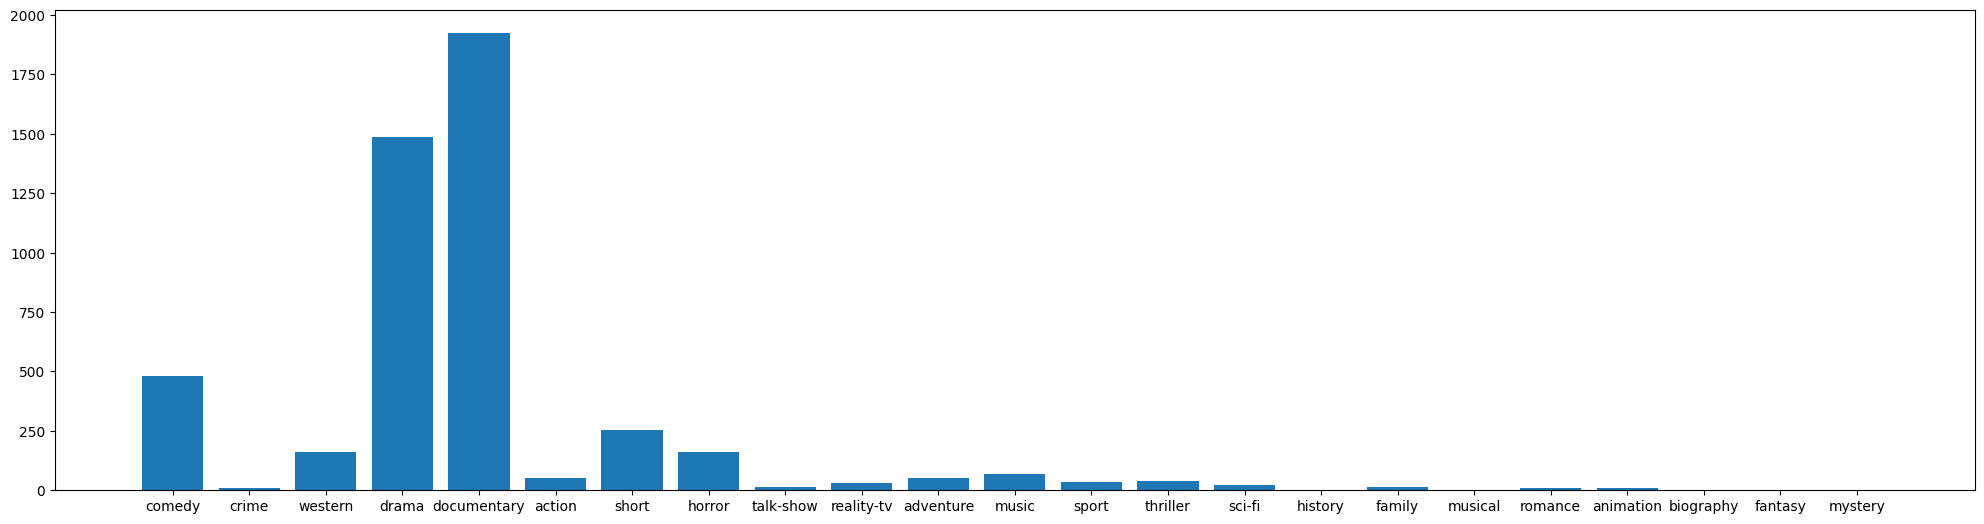

In [54]:
# visualizing the data
fig = plt.figure()
ax = fig.add_axes([1,1,3,1])
genres = list(correct.keys())
corrects = [len(correct[genre]) for genre in genres]
ax.bar(genres, corrects)
plt.show()

In [55]:
X_train = data['description']
y_train = data['genre']
X_test = data_test['description']
y_test = data_test['genre']
vocabulary = build_vocabulary(X_train, max_features=1000)
X_train_bow = transform_corpus(X_train, vocabulary)
X_test_bow = transform_corpus(X_test, vocabulary)
bag_of_words = list(vocabulary.keys())

X_train_combined = np.hstack((X_train_bow, np.array([list(correct.keys()).index(genre) for genre in y_train]).reshape(-1, 1)))
X_test_combined = np.hstack((X_test_bow, np.array([list(correct.keys()).index(genre) for genre in y_test]).reshape(-1, 1)))

#new correct dic 
model = KNN_Classifier(n_neighbors=5, metric='euclidean')
model.fit(X_train_combined, y_train)
y_pred_knn = model.predict(X_test_combined)
print("KNN Classification Report")
print(classification_report(y_test, y_pred_knn))




KNN Classification Report
              precision    recall  f1-score   support

      action         0.71      0.05        0.09       197
   adventure         0.42      1.00        0.59       116
   animation         0.71      0.71        0.71        75
   biography         0.41      0.72        0.53        40
      comedy         0.94      0.99        0.97      1117
       crime         1.00      0.05        0.10        76
 documentary         0.88      0.92        0.90      1964
       drama         0.88      0.96        0.92      2042
      family         0.76      0.87        0.81       117
     fantasy         0.39      0.19        0.25        48
     history         0.83      0.28        0.42        36
      horror         0.82      0.22        0.34       331
       music         0.80      0.46        0.59       110
     musical         0.73      0.66        0.69        41
     mystery         0.96      0.56        0.71        48
  reality-tv         0.76      0.24        0.37  

In [56]:

X_train = data['description']
y_train = data['genre']
X_test = data_test['description']
y_test = data_test['genre']

vocabulary = build_vocabulary(X_train, max_features=100)
X_train_bow = transform_corpus(X_train, vocabulary)
X_test_bow = transform_corpus(X_test, vocabulary)
bag_of_words = list(vocabulary.keys())

prior = defaultdict(int)
for genre in y_train:
    prior[genre] += 1
for genre in prior:
    prior[genre] = prior[genre]/len(y_train)

likelihood = {}
for genre in y_train.unique() :
    genre_indices = [i for i, y in enumerate(y_train) if y == genre]
    genre_data = X_train_bow[genre_indices]
    likelihood[genre] = (genre_data.sum(axis=0) + 1) / (genre_data.sum() + len(bag_of_words))

y_pred_nb = []
log_likelihood = {genre: np.log2(likelihood[genre]) for genre in likelihood}
log_prior = {genre: np.log2(prior[genre]) for genre in prior}


for doc in X_test_bow:
    log_posterior = {genre: log_prior[genre] + np.sum(doc * log_likelihood[genre]) for genre in prior}
    y_pred_nb.append(max(log_posterior, key=log_posterior.get))

print("Naive Bayes Classification Report")
print(classification_report(y_test, y_pred_nb))


Naive Bayes Classification Report
              precision    recall  f1-score   support

      action         0.00      0.00        0.00       197
   adventure         0.00      0.00        0.00       116
   animation         0.00      0.00        0.00        75
   biography         0.00      0.00        0.00        40
      comedy         0.00      0.00        0.00      1117
       crime         0.00      0.00        0.00        76
 documentary         0.00      0.00        0.00      1964
       drama         0.00      0.00        0.00      2042
      family         0.00      0.00        0.00       117
     fantasy         0.00      0.00        0.00        48
     history         0.00      0.00        0.00        36
      horror         0.00      0.00        0.00       331
       music         0.00      0.00        0.00       110
     musical         0.00      0.00        0.00        41
     mystery         0.00      0.00        0.00        48
  reality-tv         0.00      0.00      